In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2

from skimage.morphology import skeletonize

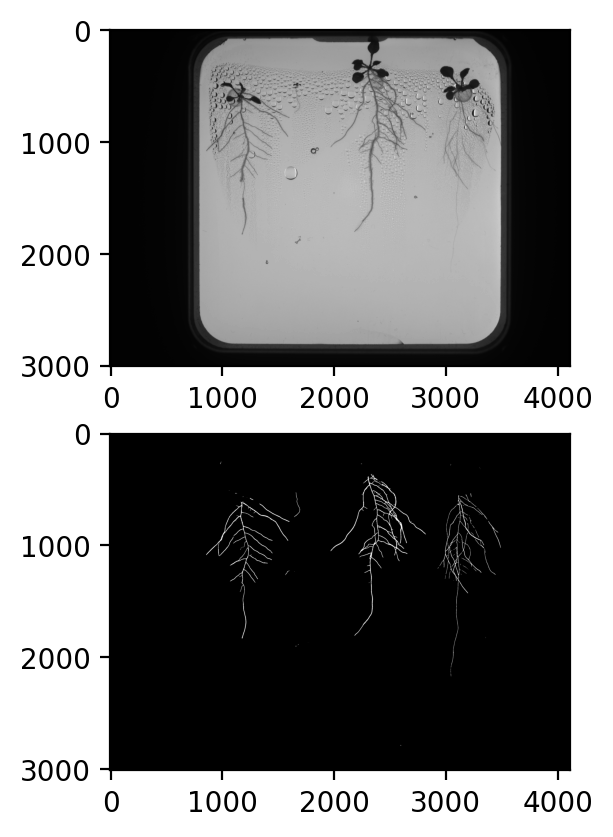

In [2]:
img_patch = ("../Task_5/task5_test_image.png")
mask_patch = ("../Task_5/task5_test_image_prediction_maciej_243552.png")

image = cv2.imread(img_patch, 0)
mask = cv2.imread(mask_patch, 0)


fig, ax = plt.subplots(2, dpi=200)
ax[0].imshow(image, cmap='gray')
ax[1].imshow(mask, cmap='gray')

In [3]:
# canvas = np.expand_dims(mask, axis=2)
# canvas = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
bin = (mask/255).astype(np.uint8)

In [4]:
print("Unique values:", np.unique(bin))

Unique values: [0 1]


# 1 attempt

In [5]:
root_mask = (mask == 255).astype(np.uint8)

In [6]:
kernel = np.ones((3, 3), np.uint8)
root_clean = cv2.morphologyEx(root_mask, cv2.MORPH_OPEN, kernel, iterations=1)
root_clean = cv2.morphologyEx(root_clean, cv2.MORPH_CLOSE, kernel, iterations=1)

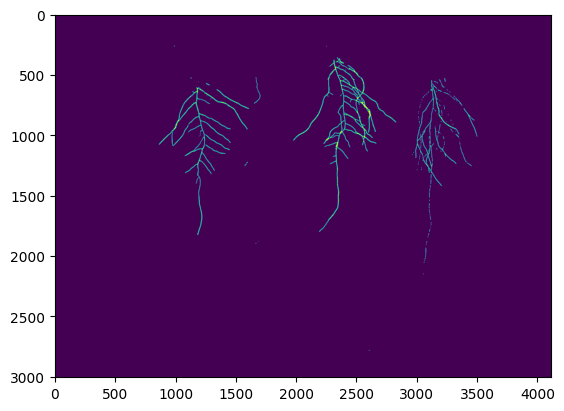

In [7]:
plt.imshow(root_clean)

In [8]:
# connectivity=8 → diagonal connections count as connected
# stats[label] = [x, y, w, h, area]
# centroids[label] = [cx, cy]
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(root_clean)


print("Number of labels (including background):", retval)
print("Number of root instances:", retval - 1)   # label 0 = background


Number of labels (including background): 202
Number of root instances: 201


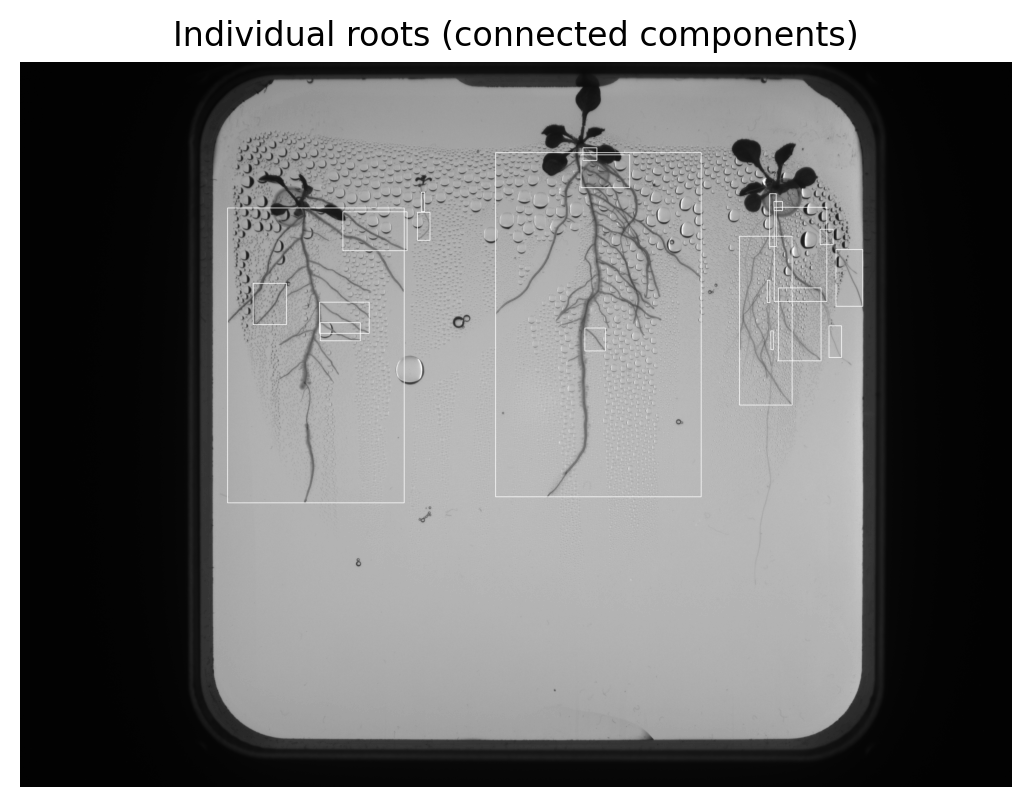

In [9]:
vis = image.copy()

for label in range(1, retval):  # skip label 0 (background)
    x, y, w, h, area = stats[label]

    # tiny noise removal
    if area < 200:
        continue

    # draw bounding box
    cv2.rectangle(vis, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure(dpi=200)
plt.imshow(vis, cmap='gray')
plt.title("Individual roots (connected components)")
plt.axis("off")
plt.show()


# 2 attempt

For last plant some roots are skipped. In this attempt I try to fix it

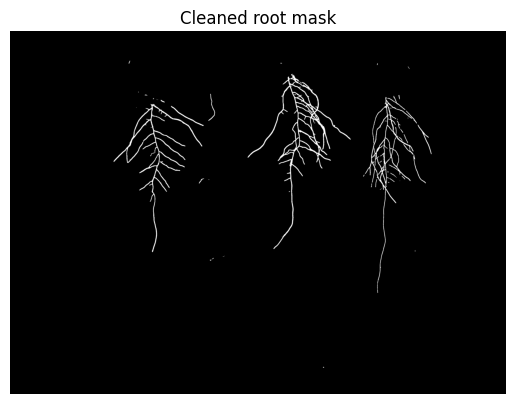

In [10]:
# Slightly dilate then erode (closing & opening) to join gaps and remove tiny bits
kernel = np.ones((3, 3), np.uint8)

# Close small gaps along roots
root_clean = cv2.dilate(bin, kernel, iterations=2)

# Remove isolated noise (I can't use bigger kernel or more iterations since discontinuity of roots apear)
root_clean = cv2.erode(root_clean, kernel, iterations=1)

plt.imshow(root_clean, cmap="gray")
plt.title("Cleaned root mask")
plt.axis("off")
plt.show()


In [11]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    root_clean, connectivity=8
)

print("Number of labels (including background):", num_labels)
print("Number of root candidates:", num_labels - 1)  # label 0 is background


Number of labels (including background): 60
Number of root candidates: 59


In [12]:
stats

array([[       0,        0,     4112,     3006, 12200628],
       [     983,      246,       13,       23,      130],
       [    2242,      264,       13,        5,       57],
       [    3042,      267,        7,       15,       65],
       [    3298,      295,       14,       19,       70],
       [    1970,      355,      855,     1450,    65500],
       [    2405,      422,       14,       13,       74],
       [    2332,      452,        6,        8,       33],
       [    2471,      485,        4,        5,       18],
       [    1062,      503,        6,        5,       25],
       [    1644,      520,       56,      224,     1461],
       [    2358,      523,       12,        7,       59],
       [    1117,      527,       22,        8,      110],
       [    3221,      530,       10,       35,      208],
       [    3128,      537,      150,      117,     1340],
       [    2943,      547,      402,     1622,    38034],
       [    1185,      555,        8,        9,       50

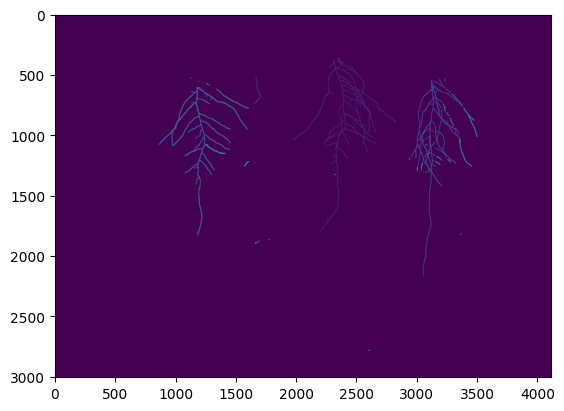

In [13]:
plt.imshow(labels)

Now is way less than before 202 -> 56

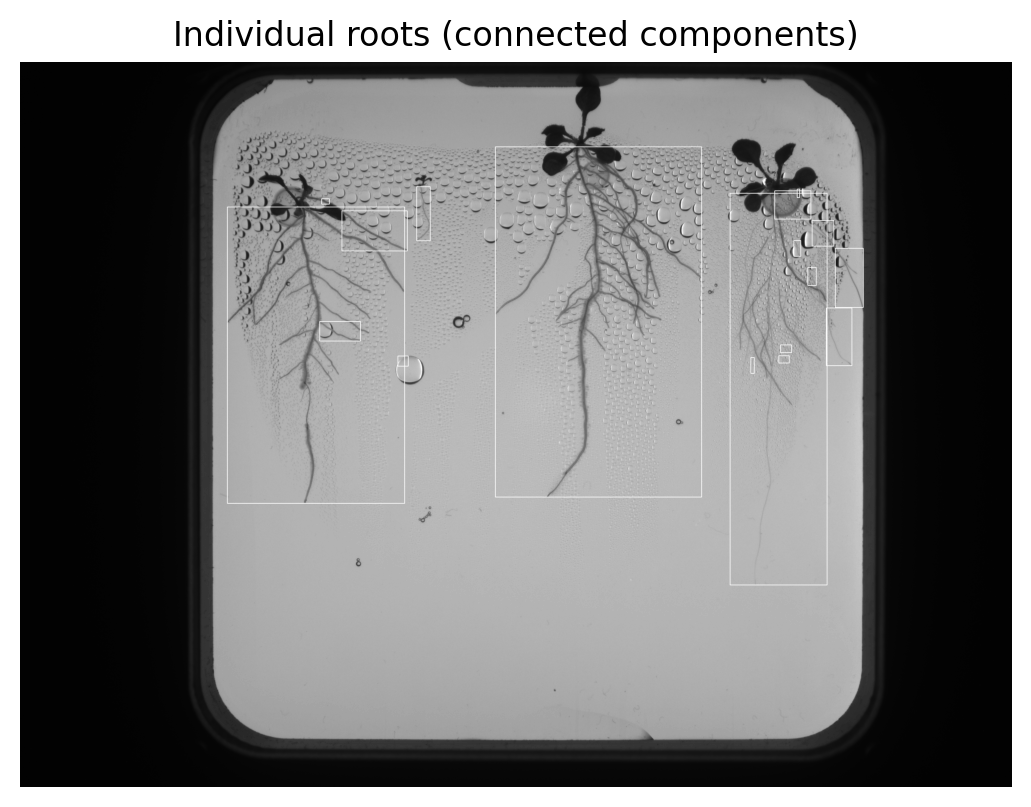

In [14]:
box = image.copy()

for label in range(1, num_labels):  # skip background
    x, y, w, h, area = stats[label]

    # noise removal for area < x (100, 200, 500 etc.)
    if area < 200:
        continue

    # draw bounding box
    cv2.rectangle(box, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure(dpi=200)
plt.imshow(box, cmap='gray')
plt.title("Individual roots (connected components)")
plt.axis("off")
plt.show()


This is still not enough. A lot of strange small parts are taken into consideration

# 3 attempt

This attempt is focused to get top 4 (since we have 4 plants) biggest bounding boxes

In [15]:
import numpy as np

areas = stats[1:, cv2.CC_STAT_AREA]          # skip background row 0
labels_idx = np.arange(1, num_labels)        # label IDs for components 1..N

# sort labels by area (descending)
sorted_idx = labels_idx[np.argsort(-areas)]

# keep 4 biggest (4 palnts in this case)
top_k = 8
root_labels = sorted_idx[:top_k]
print("Selected labels:", root_labels)


Selected labels: [ 5 20 15 21 30 34 36 10]


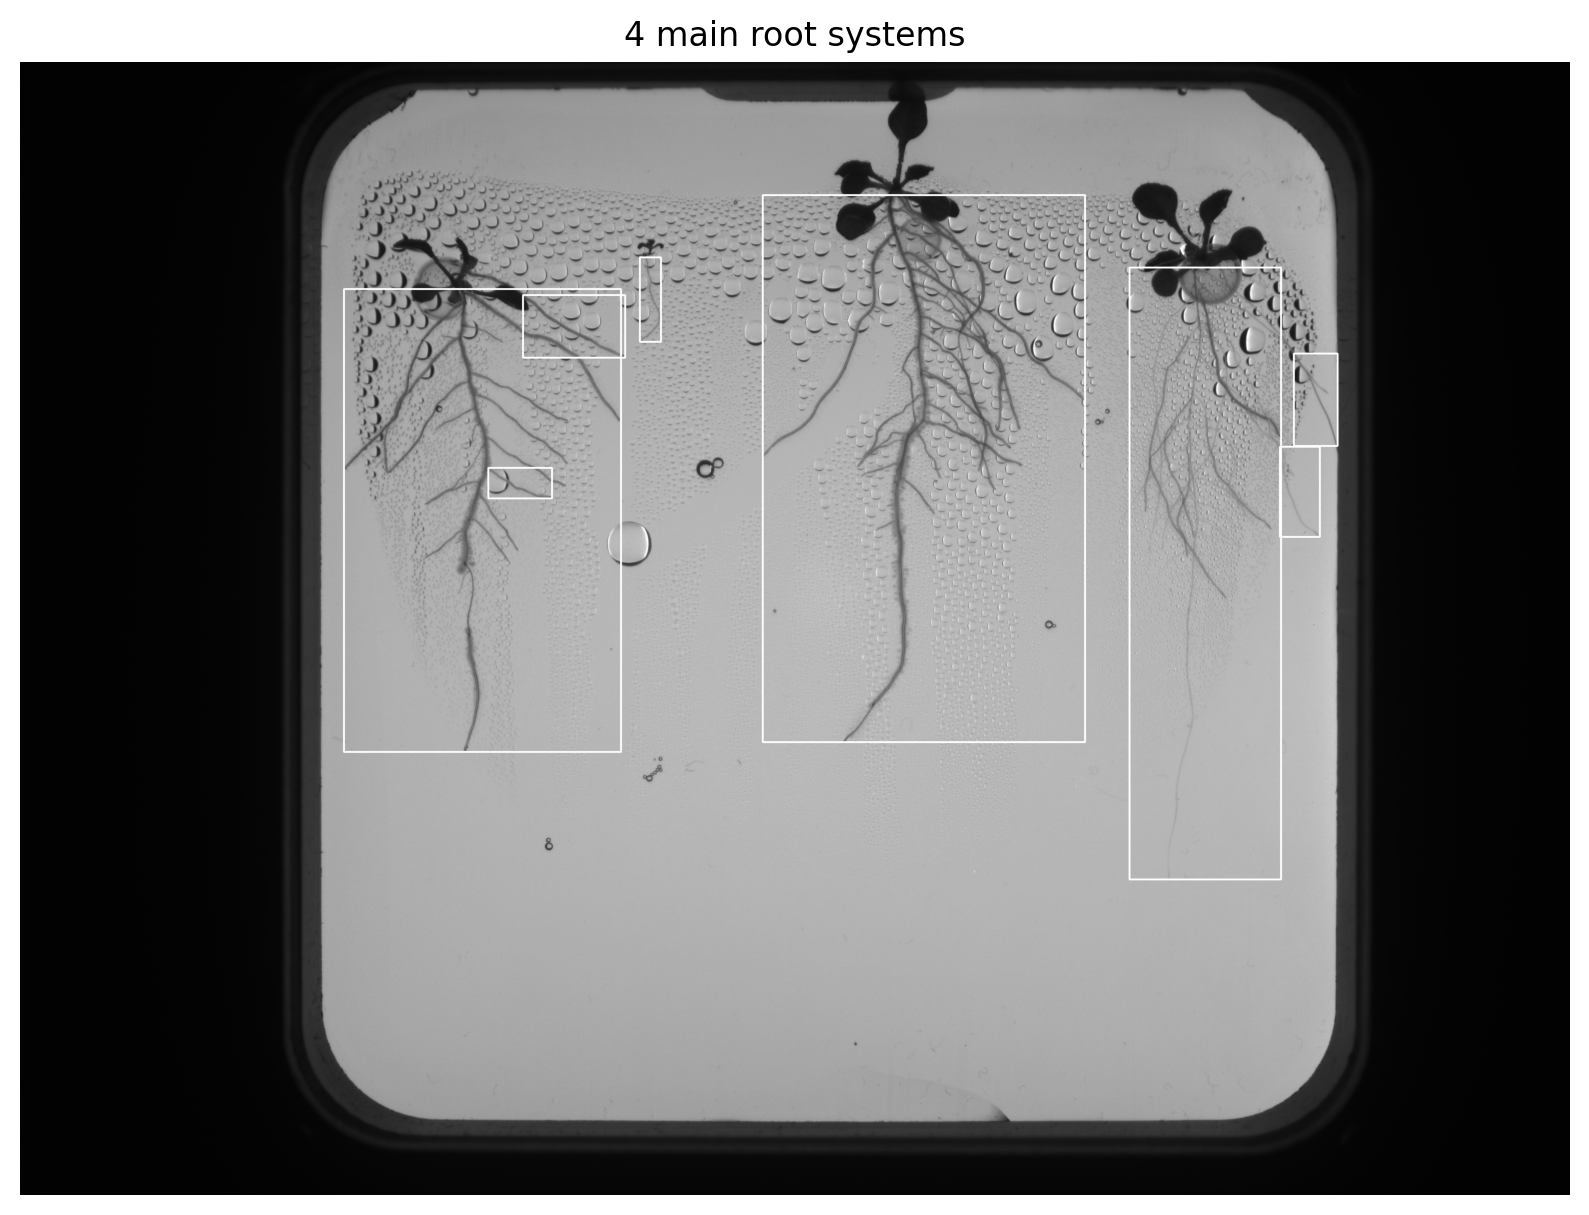

In [16]:
vis = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# drawing bounding boxes
for label in root_labels:
    x = stats[label, cv2.CC_STAT_LEFT]
    y = stats[label, cv2.CC_STAT_TOP]
    w = stats[label, cv2.CC_STAT_WIDTH]
    h = stats[label, cv2.CC_STAT_HEIGHT]

    cv2.rectangle(vis, (x, y), (x+w, y+h), (255, 255, 255), 3)

plt.figure(figsize=(10, 10), dpi=200)
plt.imshow(vis)
plt.axis("off")
plt.title("4 main root systems")
plt.show()


After manual inspection the labels of roots are 5, 20, 15, and 10

In [17]:
choosen = [5, 10, 15, 20]

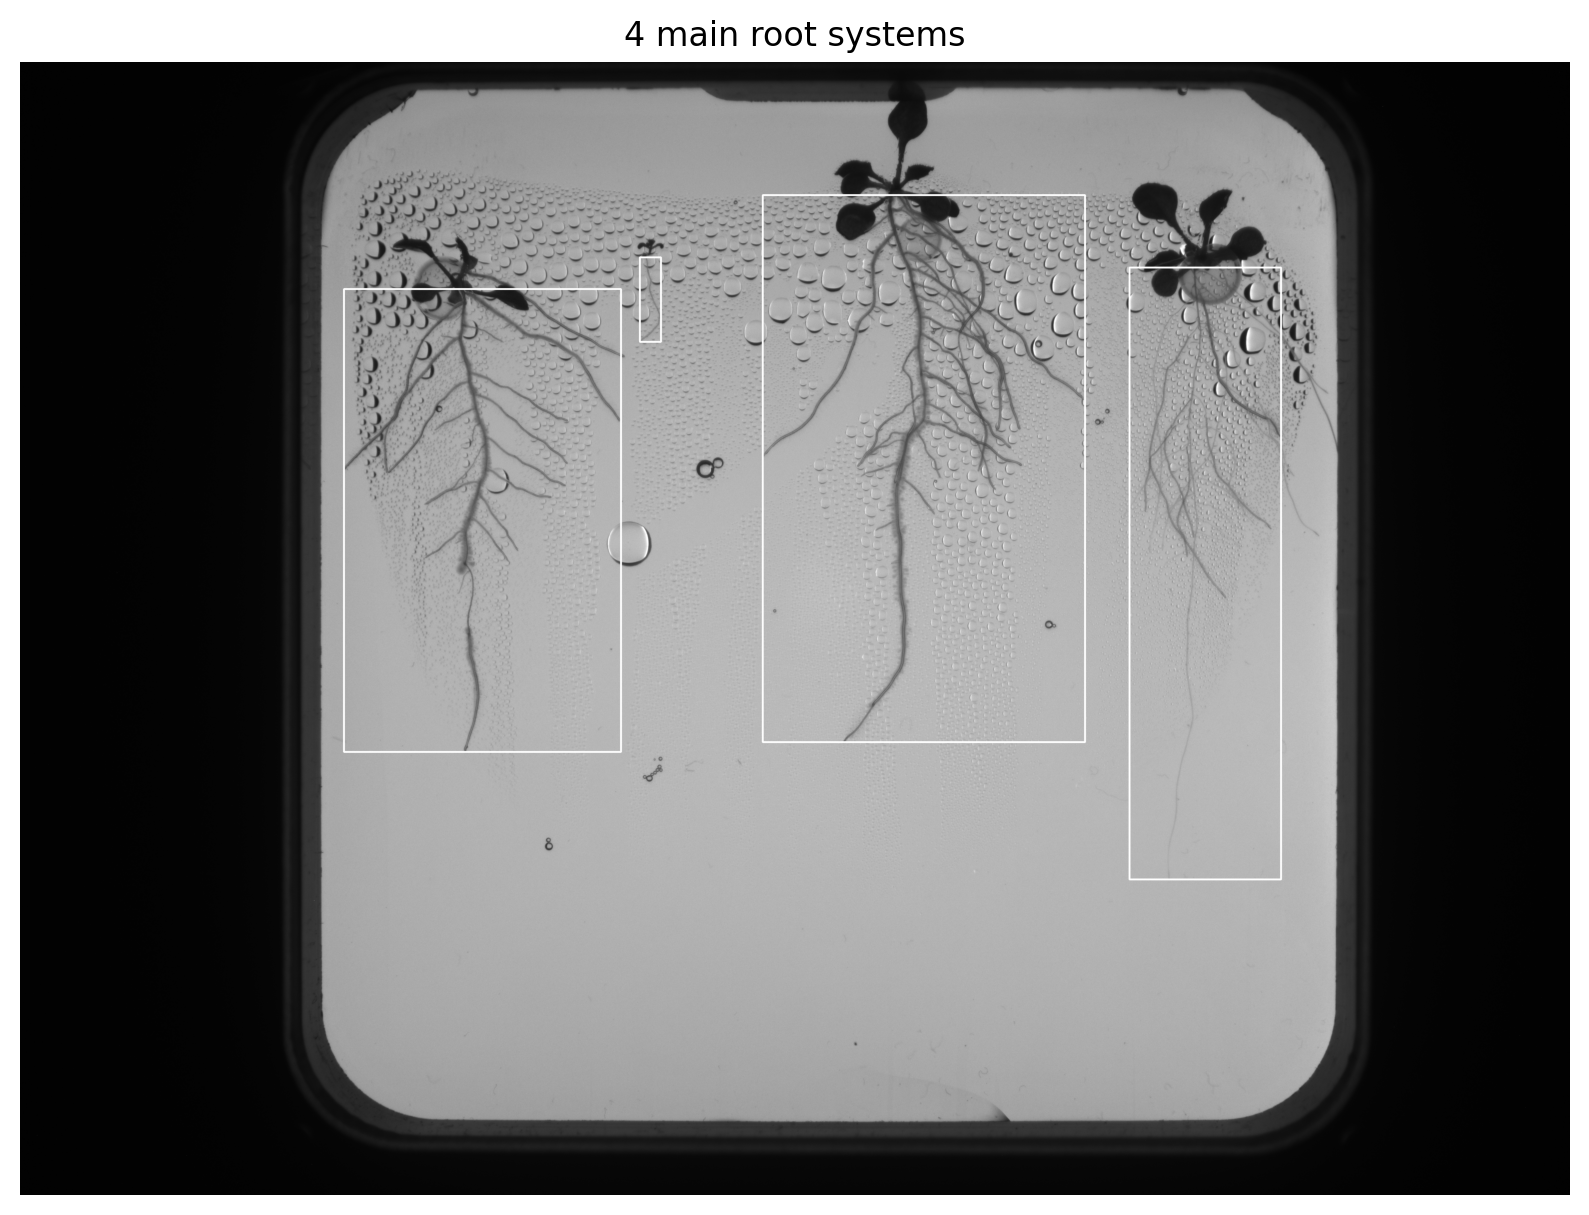

In [18]:
vis = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# drawing bounding boxes
for label in choosen:
    x = stats[label, cv2.CC_STAT_LEFT]
    y = stats[label, cv2.CC_STAT_TOP]
    w = stats[label, cv2.CC_STAT_WIDTH]
    h = stats[label, cv2.CC_STAT_HEIGHT]

    cv2.rectangle(vis, (x, y), (x+w, y+h), (255, 255, 255), 3)

plt.figure(figsize=(10, 10), dpi=200)
plt.imshow(vis)
plt.axis("off")
plt.title("4 main root systems")
plt.show()


# 4 attempt

For this attempt I will try to use shoot mask also. I believe that it might reduce ammout of blob and will let me isolate the plants and it's root system.

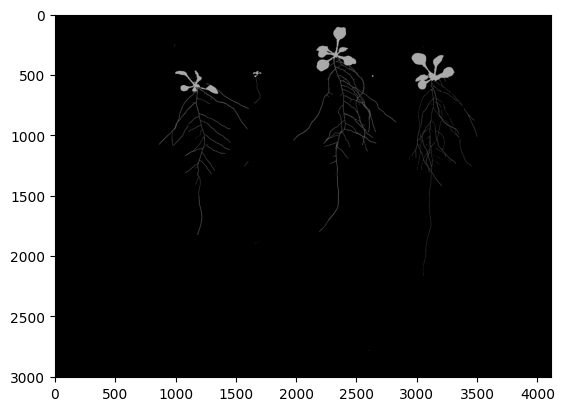

In [19]:
mask_test_path = ("task5_test_image_pred_to_task_6.png")
mask_test = cv2.imread(mask_test_path, 0)
plt.imshow(mask_test, cmap='gray')

In [20]:
np.unique(mask_test)

array([  0,  85, 170, 255], dtype=uint8)

In [21]:
root_mask = (mask_test > 0).astype(np.uint8)

# Slightly dilate then erode (closing & opening) to join gaps and remove tiny bits
kernel = np.ones((3, 3), np.uint8)

# Close small gaps along roots
root_clean = cv2.dilate(root_mask, kernel, iterations=3)

# Remove isolated noise (I can't use bigger kernel or more iterations since discontinuity of roots apear)
root_clean = cv2.erode(root_clean, kernel, iterations=1)

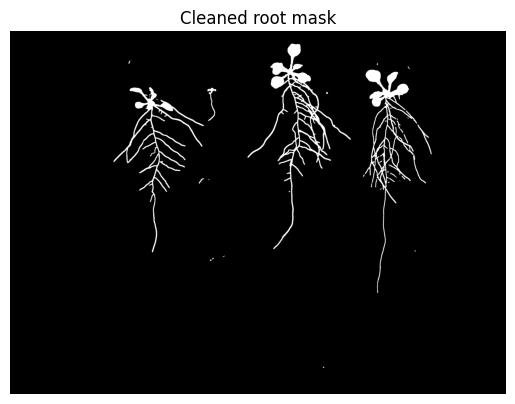

In [22]:
plt.imshow(root_clean, cmap="gray")
plt.title("Cleaned root mask")
plt.axis("off")
plt.show()

In [23]:
np.unique(root_clean)

array([0, 1], dtype=uint8)

In [24]:
# root_mask = (root_clean == 1).astype(np.uint8)

retval, labels, stats, centroids = cv2.connectedComponentsWithStats(root_clean)


print("Number of labels (including background):", retval)
print("Number of root instances:", retval - 1)   # label 0 = background

Number of labels (including background): 38
Number of root instances: 37


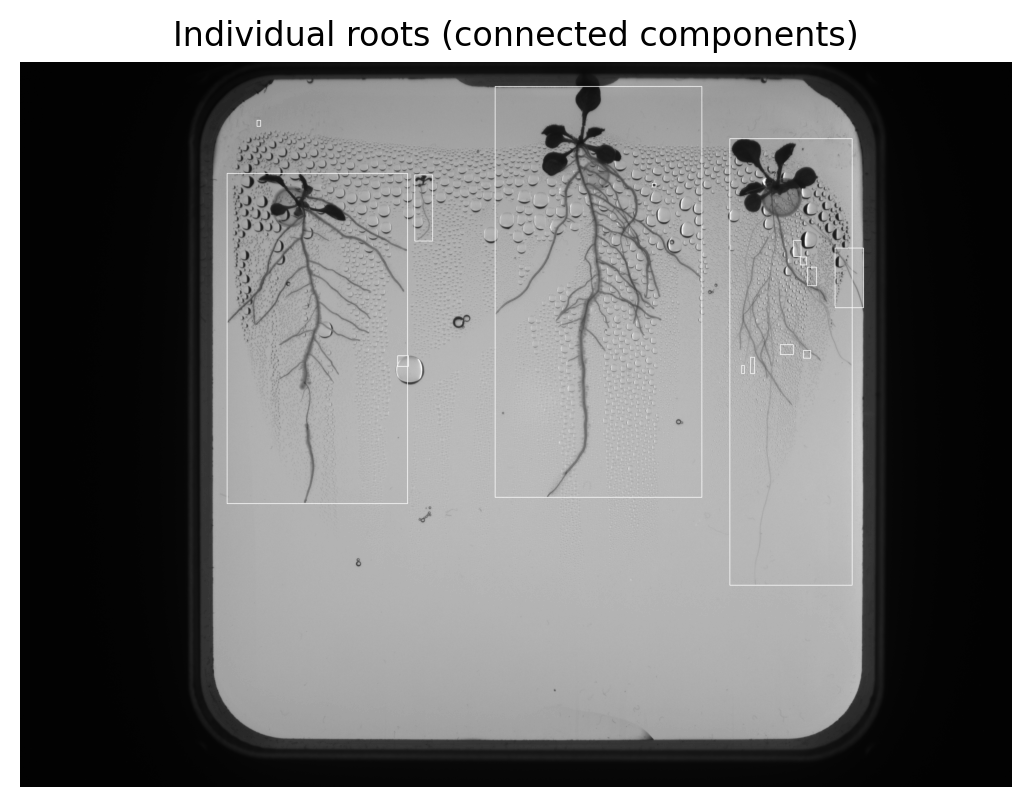

In [25]:
box = image.copy()

for label in range(1, retval):  # skip background
    x, y, w, h, area = stats[label]

    # noise removal for area < x (100, 200, 500 etc.)
    if area < 200:
        continue

    # draw bounding box
    cv2.rectangle(box, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure(dpi=200)
plt.imshow(box, cmap='gray')
plt.title("Individual roots (connected components)")
plt.axis("off")
plt.show()


In [26]:
import numpy as np

areas = stats[1:, cv2.CC_STAT_AREA]          # skip background row 0
labels_idx = np.arange(1, retval)        # label IDs for components 1..N

# sort labels by area (descending)
sorted_idx = labels_idx[np.argsort(-areas)]

# keep 4 biggest (4 palnts in this case)
top_k = 4
root_labels = sorted_idx[:top_k]
print("Selected labels:", root_labels)


Selected labels: [1 5 6 7]


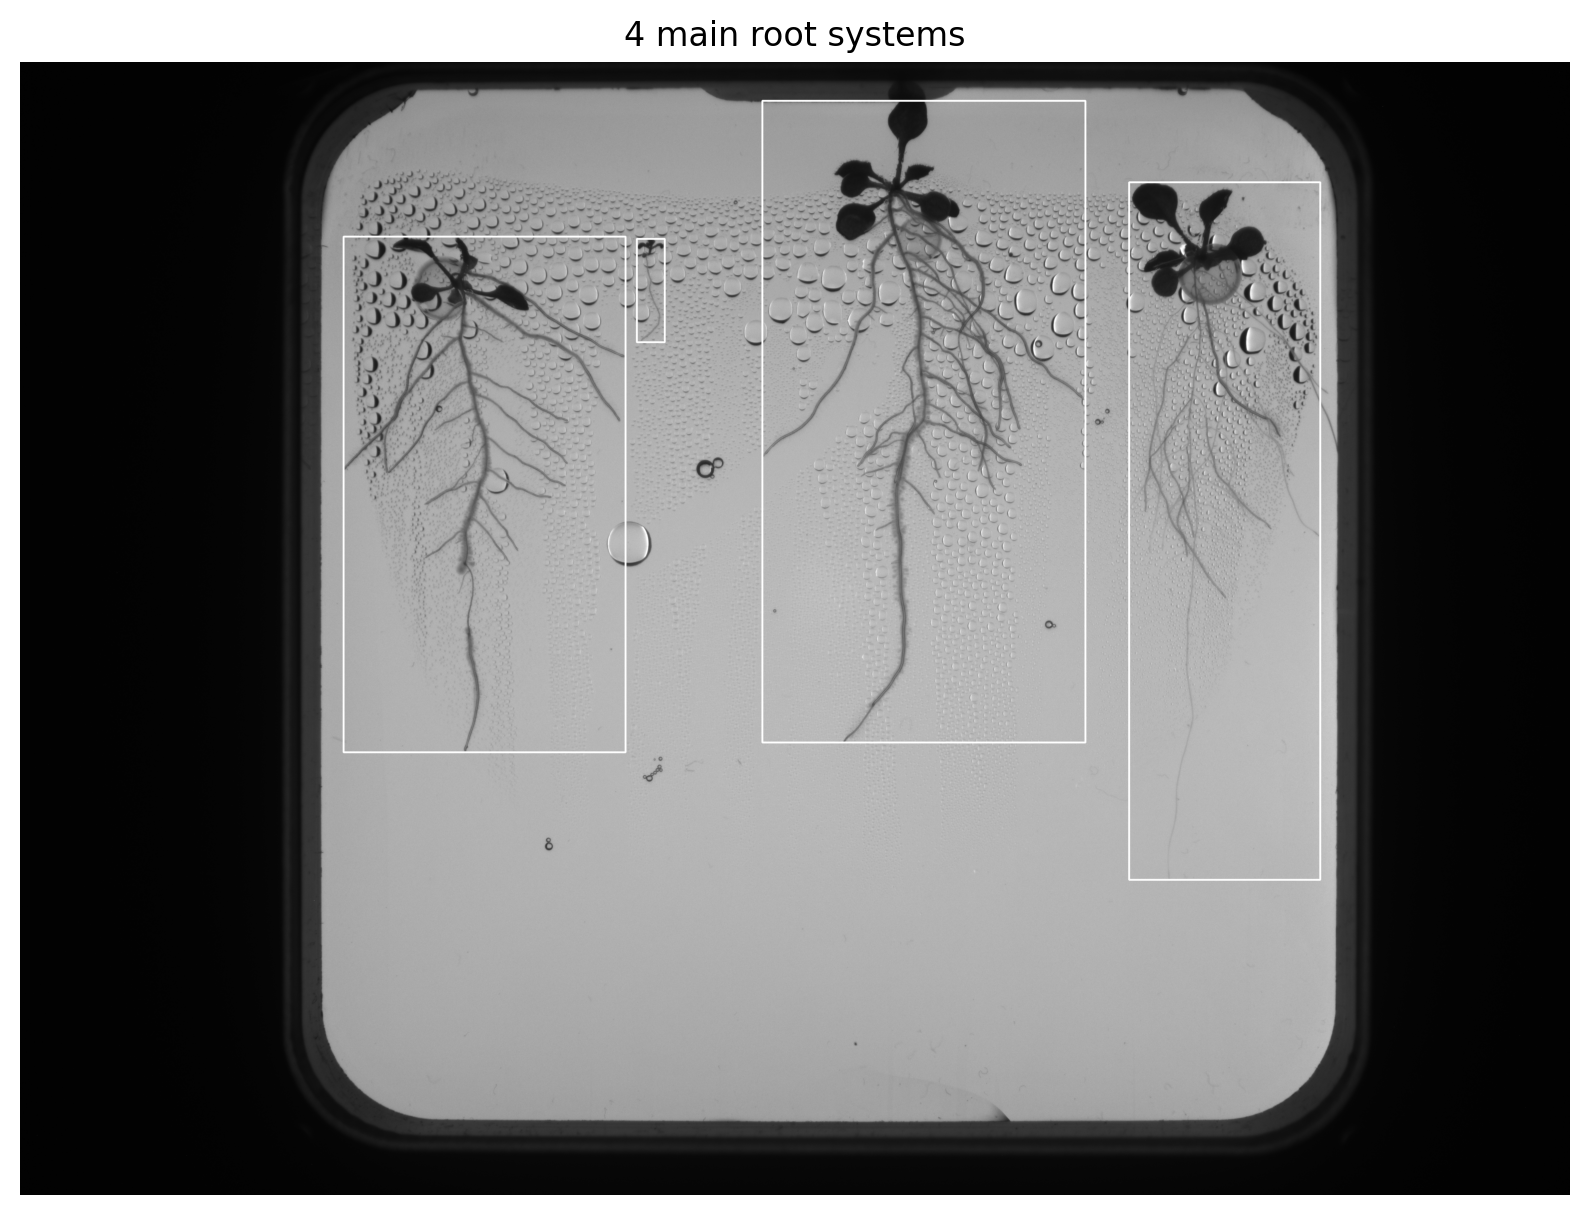

In [27]:
vis = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# drawing bounding boxes
for label in root_labels:
    x = stats[label, cv2.CC_STAT_LEFT]
    y = stats[label, cv2.CC_STAT_TOP]
    w = stats[label, cv2.CC_STAT_WIDTH]
    h = stats[label, cv2.CC_STAT_HEIGHT]

    cv2.rectangle(vis, (x, y), (x+w, y+h), (255, 255, 255), 3)

plt.figure(figsize=(10, 10), dpi=200)
plt.imshow(vis)
plt.axis("off")
plt.title("4 main root systems")
plt.show()


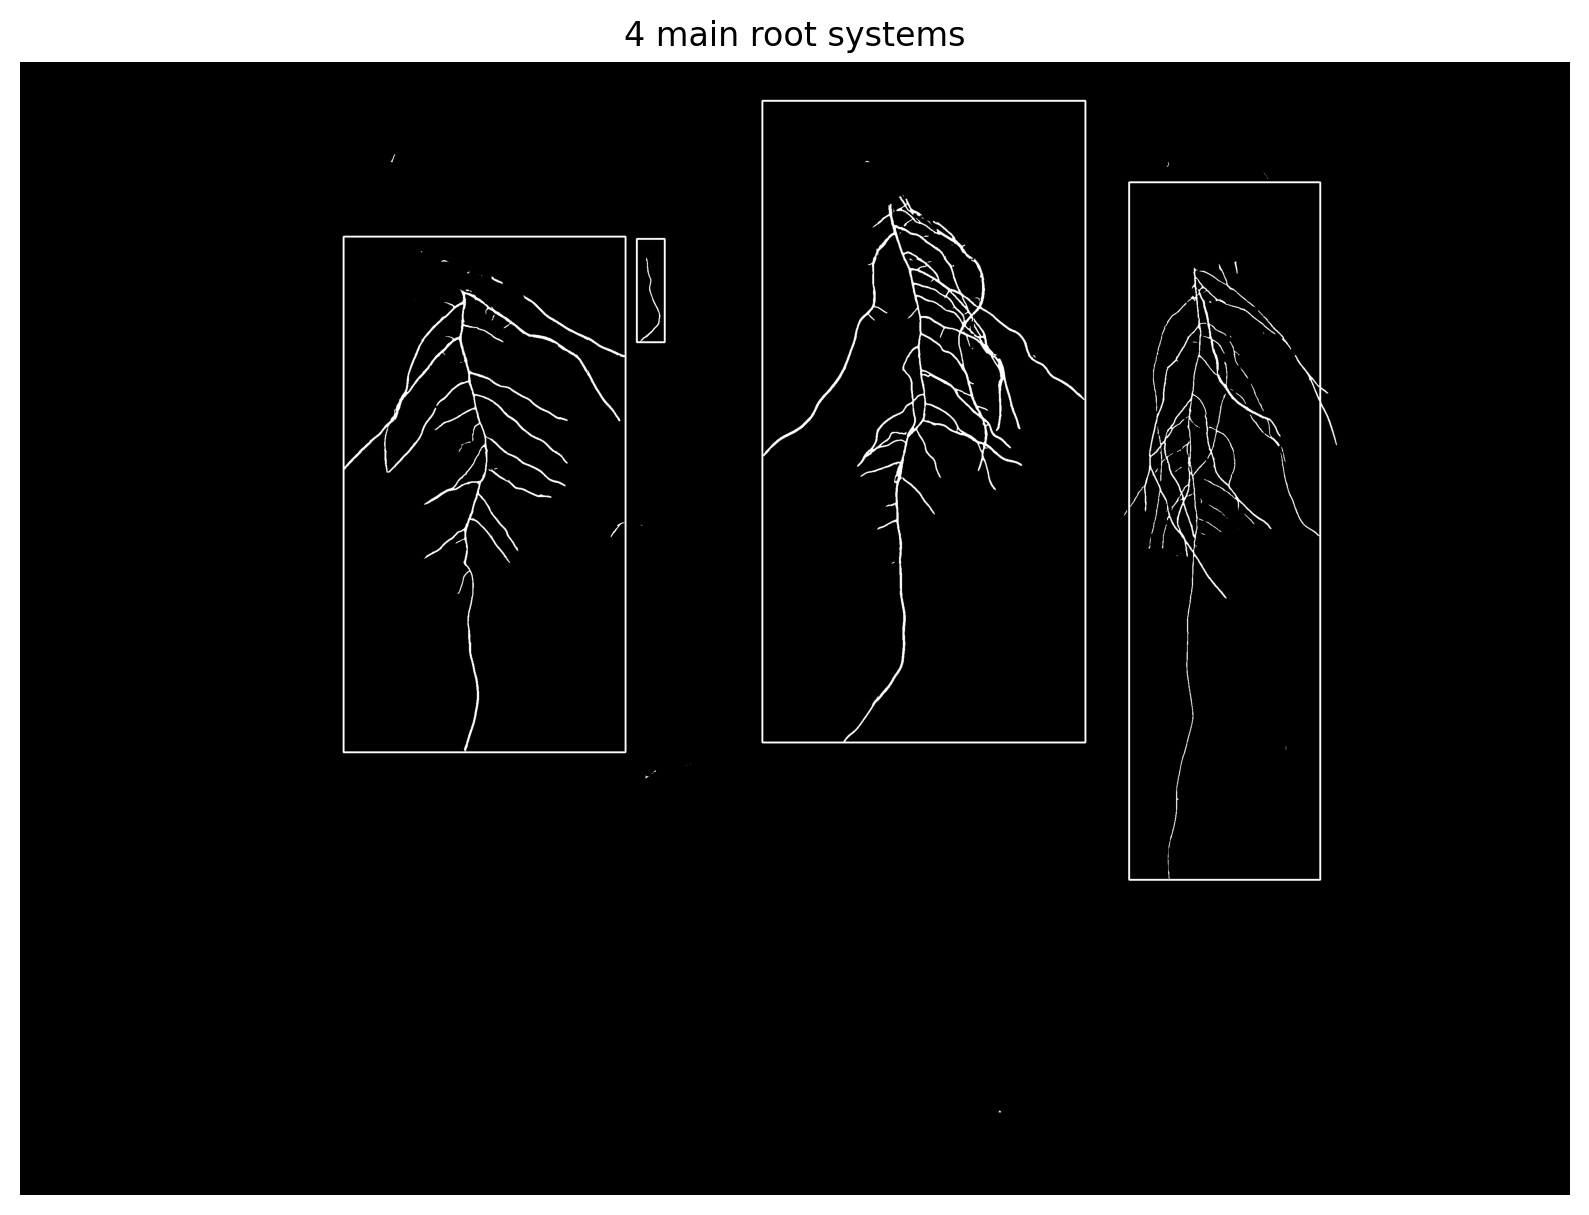

In [28]:
vis = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# drawing bounding boxes
for label in root_labels:
    x = stats[label, cv2.CC_STAT_LEFT]
    y = stats[label, cv2.CC_STAT_TOP]
    w = stats[label, cv2.CC_STAT_WIDTH]
    h = stats[label, cv2.CC_STAT_HEIGHT]

    cv2.rectangle(mask, (x, y), (x+w, y+h), (255, 255, 255), 3)

plt.figure(figsize=(10, 10), dpi=200)
plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.title("4 main root systems")
plt.show()


# Kaggle

In [29]:
def extract_dish(img):
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # convert to grayscale for Otsu
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # height, widh, center of image
    height, widh = img.shape[:2]
    
    # apply Otsu thresholding
    th, output_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(f'Otsu algorithm selected the following threshold: {th}')

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    # the biggest blob (object) on each image is Petri dish
    # -infinity - to ensure any score is better
    best_label, best_score = None, -np.inf

    # in loop center is used since Petri dish is near center
    for lab in range(1, num_labels):
        """
        range(1...) - skip label 0 as it is the background
        stats are in format: [x, y, w, h, area] where:
            x.y - top-left corner
            w,h - width and height
            area - area in pixels
        centroids are in format: [cx, cy]
        """
        x, y, w, h, area = stats[lab]
        cx, cy = centroids[lab]

        # big area, near center, square shape
        area_score = area
        center_score = -np.linalg.norm([cx - widh/2, cy - height/2])
        
        #checking aspect ratio
        aspect = w / h
        square_score = -abs(aspect - 1.0)

        # check scores weights (area, square, center)
        score = (1.0 * area_score + 500.0 * square_score + 1000.0 * center_score)

        if score > best_score:
            best_score, best_label = score, lab
    
    x, y, w, h, area = stats[best_label]

    # ensure square that the Pertri dish is fully inside margin is added
    x0 = max(x, 0)
    y0 = max(y, 0)

    # crop
    side = min(w, h)
    x1 = x + side
    y1 = y + side
    extracted_img = img[y0:y1, x0:x1, :]

    # check crop is square
    assert extracted_img.shape[0] == extracted_img.shape[1], "Crop is not square!"
    return extracted_img, (y0, y1, x0, x1)

def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding
    
    if image.ndim == 2:
        border_val = 0
    else:
        border_val = [0, 0, 0]

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image, (top_padding, bottom_padding, left_padding, right_padding)

def unpadder(padded_image, padding):
    top_padding, bottom_padding, left_padding, right_padding = padding

    # remove the exact padding added during padder()
    h_end = None if bottom_padding == 0 else -bottom_padding
    w_end = None if right_padding  == 0 else -right_padding

    unpadded = padded_image[
        top_padding : h_end,
        left_padding : w_end
    ]

    return unpadded

In [30]:
from patchify import patchify, unpatchify
import os
import glob

im_dir = "Kaggle\\data\\*png"
out_dir = "Kaggle\\test"
os.makedirs(out_dir, exist_ok=True)

patch_size = 256

image_paths = sorted(glob.glob(im_dir))

for path in image_paths:
    print("Processing:", path)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # grayscale

    dish, bbox = extract_dish(img)                # crop square Petri dish
    dish_padded, padding = padder(dish, patch_size)

    stem = os.path.splitext(os.path.basename(path))[0]
    out_path = os.path.join(out_dir, f"{stem}_petri_padded.png")

    cv2.imwrite(out_path, dish_padded)
    print("Saved:", out_path)

Processing: Kaggle\data\test_image_01.png
Otsu algorithm selected the following threshold: 103.0
Saved: Kaggle\test\test_image_01_petri_padded.png
Processing: Kaggle\data\test_image_02.png
Otsu algorithm selected the following threshold: 102.0
Saved: Kaggle\test\test_image_02_petri_padded.png
Processing: Kaggle\data\test_image_03.png
Otsu algorithm selected the following threshold: 101.0
Saved: Kaggle\test\test_image_03_petri_padded.png
Processing: Kaggle\data\test_image_04.png
Otsu algorithm selected the following threshold: 94.0
Saved: Kaggle\test\test_image_04_petri_padded.png
Processing: Kaggle\data\test_image_05.png
Otsu algorithm selected the following threshold: 94.0
Saved: Kaggle\test\test_image_05_petri_padded.png
Processing: Kaggle\data\test_image_06.png
Otsu algorithm selected the following threshold: 94.0
Saved: Kaggle\test\test_image_06_petri_padded.png
Processing: Kaggle\data\test_image_07.png
Otsu algorithm selected the following threshold: 94.0
Saved: Kaggle\test\test_i

In [31]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [32]:
# Load the model you trained in task5_training.ipynb
from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = f'maciej_czerniak_243552_multiclass_unet_model_patchsize{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [33]:
import glob
import os
import cv2
import numpy as np
from patchify import patchify

patch_size = 256

# where your test images are
pattern = r"Kaggle\\test\\*.png"
image_paths = sorted(glob.glob(pattern))
print("Found test images:", len(image_paths))

# where to save predicted masks (per Petri dish)
out_dir = r"Kaggle\\pred_masks_dish"
os.makedirs(out_dir, exist_ok=True)

for path in image_paths:
    print("\nProcessing:", path)
    img = cv2.imread(path)       # color image for extract_dish / model
    if img is None:
        print("WARNING: could not read", path)
        continue

    # 1) extract Petri dish (color)
    petri_dish, bbox = extract_dish(img)   # your function

    # 2) pad Petri dish so it is divisible by patch_size
    petri_dish_padded, padding = padder(petri_dish, patch_size)
    H_pad, W_pad = petri_dish_padded.shape[:2]

    # 3) ensure 3 channels for the model
    if petri_dish_padded.ndim == 2:
        petri_dish_padded_rgb = cv2.cvtColor(petri_dish_padded,
                                             cv2.COLOR_GRAY2RGB)
    else:
        petri_dish_padded_rgb = petri_dish_padded

    # 4) PATCHIFY
    patches = patchify(petri_dish_padded_rgb,
                       (patch_size, patch_size, 3),
                       step=patch_size)
    n_rows, n_cols = patches.shape[0], patches.shape[1]

    # -> (n_rows * n_cols, patch_size, patch_size, 3)
    patches_for_model = patches.reshape(-1, patch_size, patch_size, 3)
    patches_for_model = patches_for_model.astype("float32")

    print(f"  patches_for_model: {patches_for_model.shape}")

    # 5) PREDICT
    predicted_masks = model.predict(patches_for_model)
    n_classes = predicted_masks.shape[-1]
    print("  predicted_masks shape:", predicted_masks.shape)

    # 6) ARGMAX over classes -> label for each pixel
    predicted_classes = np.argmax(predicted_masks, axis=-1).astype(np.uint8)
    # shape: (n_rows * n_cols, patch_size, patch_size)
    print("  unique labels:", np.unique(predicted_classes))

    # 7) UNPATCHIFY back to padded dish mask
    predicted_grid = predicted_classes.reshape(
        n_rows, n_cols, patch_size, patch_size
    )
    # your unpatchify takes (grid, out_shape)
    predicted_mask_padded = unpatchify(
        predicted_grid,
        petri_dish_padded_rgb.shape[:2]
    )
    # predicted_mask_padded: (H_pad, W_pad)

    # 8) UNPAD back to original dish crop
    predicted_mask_dish = unpadder(predicted_mask_padded, padding)
    print("  predicted_mask_dish shape:", predicted_mask_dish.shape)

    # 9) SAVE dish mask
    stem = os.path.splitext(os.path.basename(path))[0]
    out_path = os.path.join(out_dir, f"{stem}_mask.png")

    # if you want a visible mask for a report: multiply classes by 50 or 255
    cv2.imwrite(out_path, predicted_mask_dish)
    print("  saved:", out_path)


Found test images: 19

Processing: Kaggle\\test\test_image_01_petri_padded.png
Otsu algorithm selected the following threshold: 112.0
  patches_for_model: (121, 256, 256, 3)
4/4 [==============================] - 19s 2s/step
  predicted_masks shape: (121, 256, 256, 4)
  unique labels: [0 1 2 3]
  predicted_mask_dish shape: (2763, 2763)
  saved: Kaggle\\pred_masks_dish\test_image_01_petri_padded_mask.png

Processing: Kaggle\\test\test_image_02_petri_padded.png
Otsu algorithm selected the following threshold: 108.0
  patches_for_model: (121, 256, 256, 3)
4/4 [==============================] - 0s 82ms/step
  predicted_masks shape: (121, 256, 256, 4)
  unique labels: [0 1 2 3]
  predicted_mask_dish shape: (2764, 2764)
  saved: Kaggle\\pred_masks_dish\test_image_02_petri_padded_mask.png

Processing: Kaggle\\test\test_image_03_petri_padded.png
Otsu algorithm selected the following threshold: 106.0
  patches_for_model: (121, 256, 256, 3)
4/4 [==============================] - 0s 80ms/step
  p

Found masks: 19


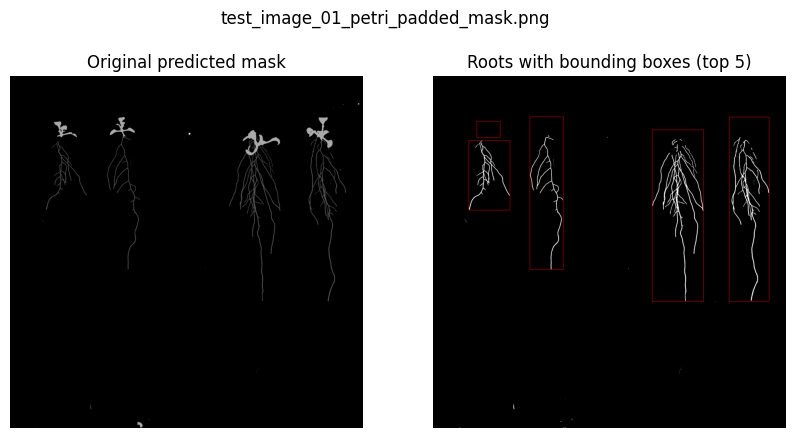

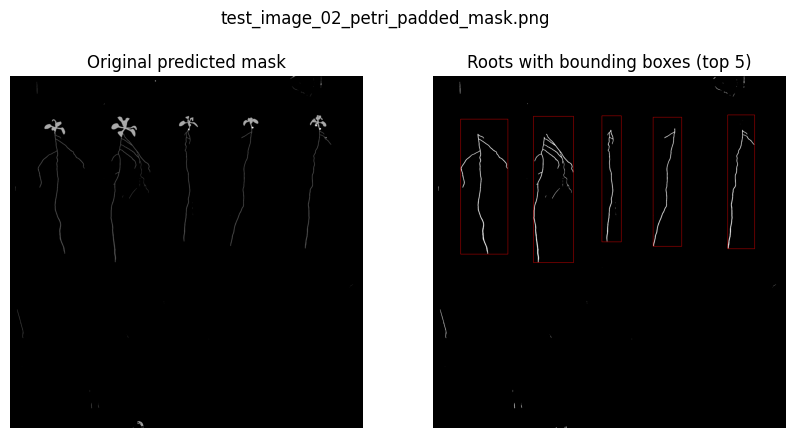

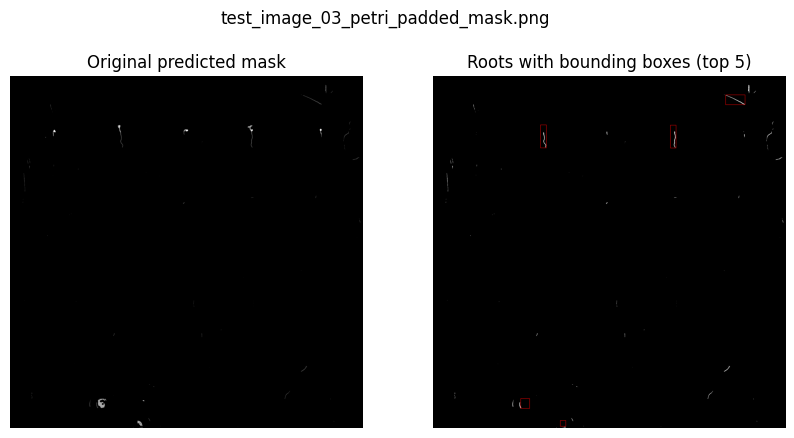

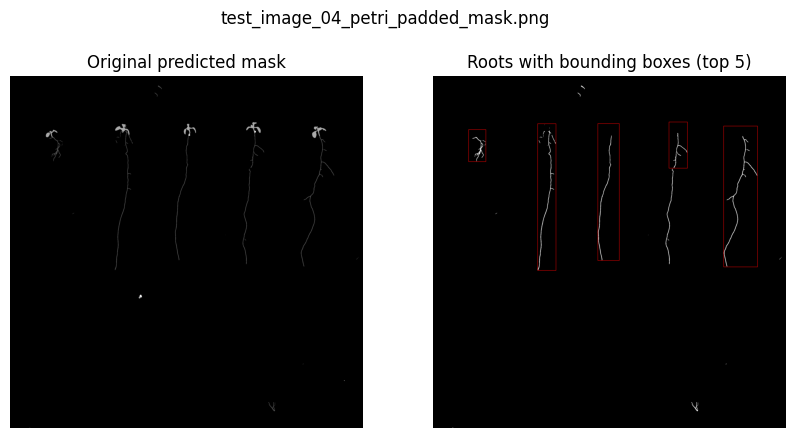

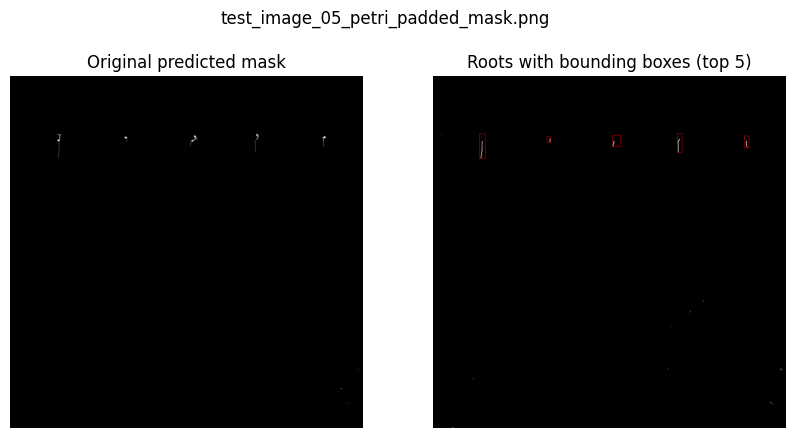

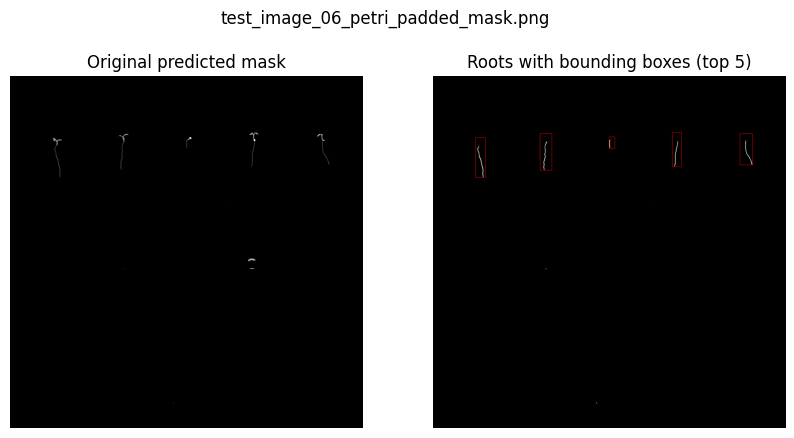

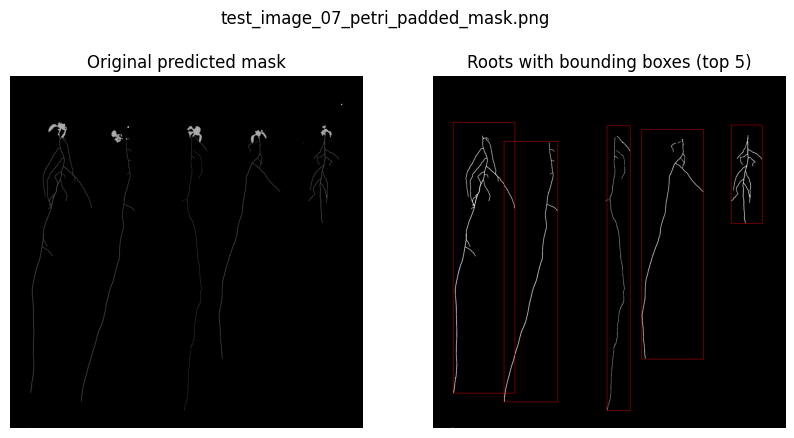

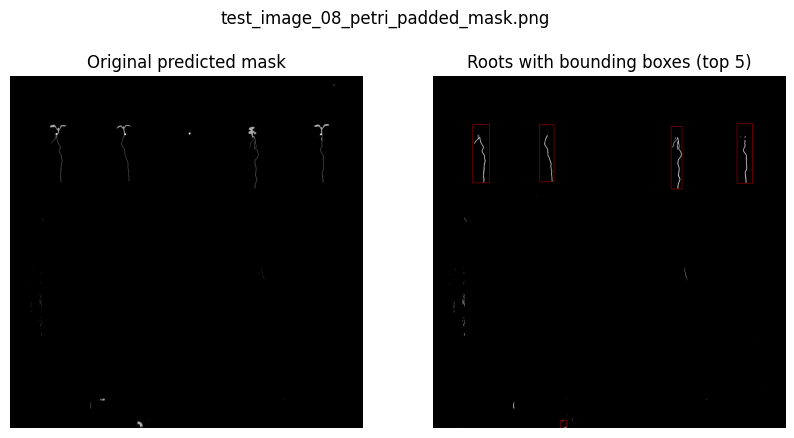

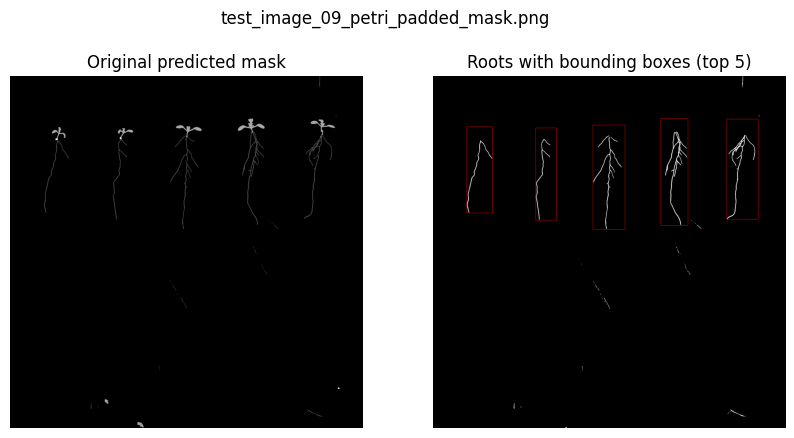

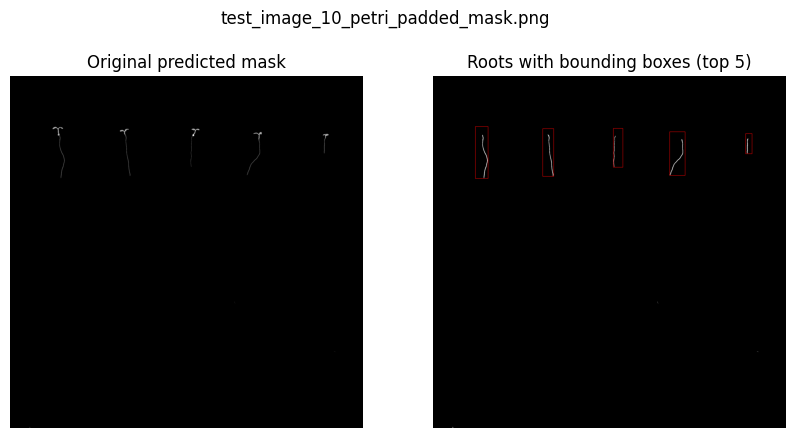

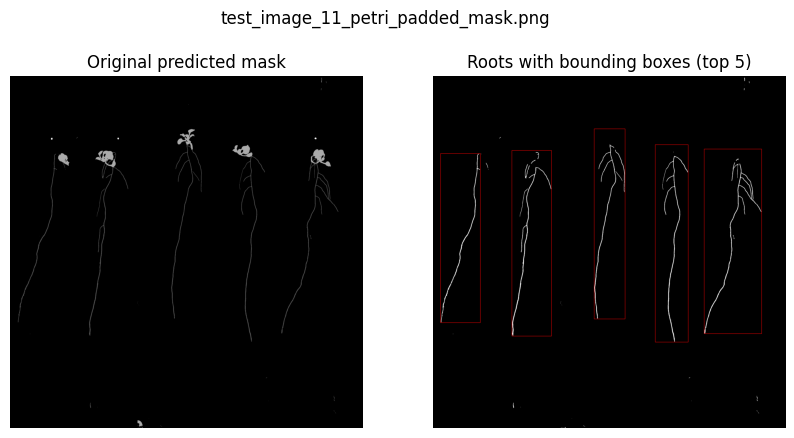

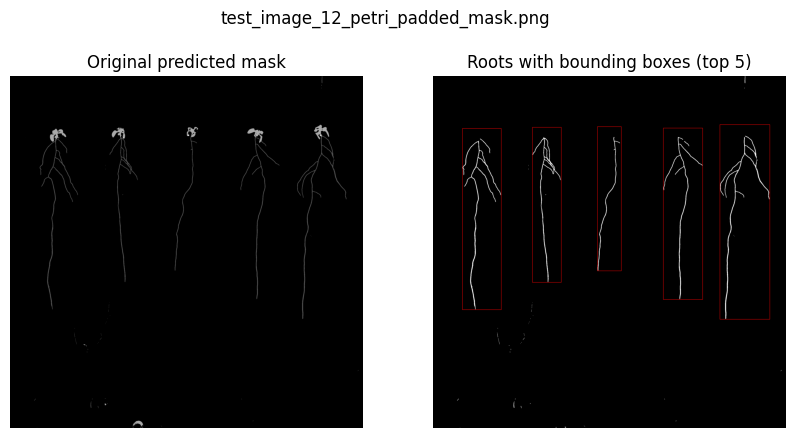

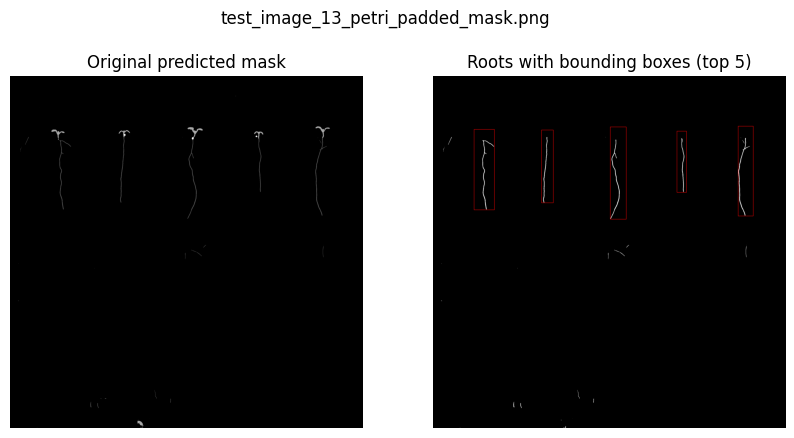

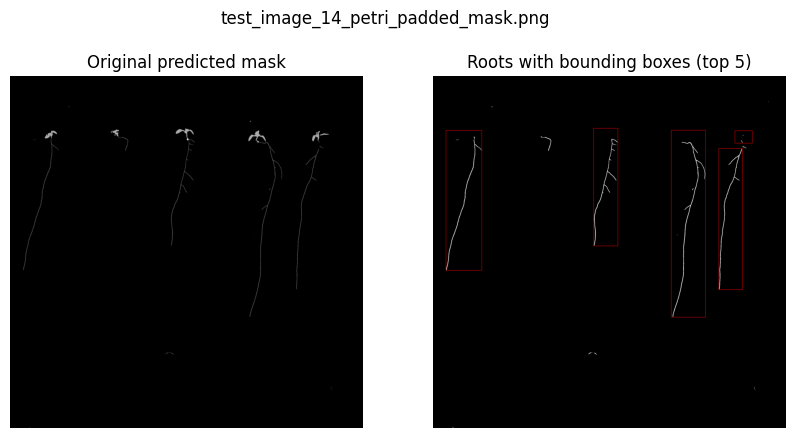

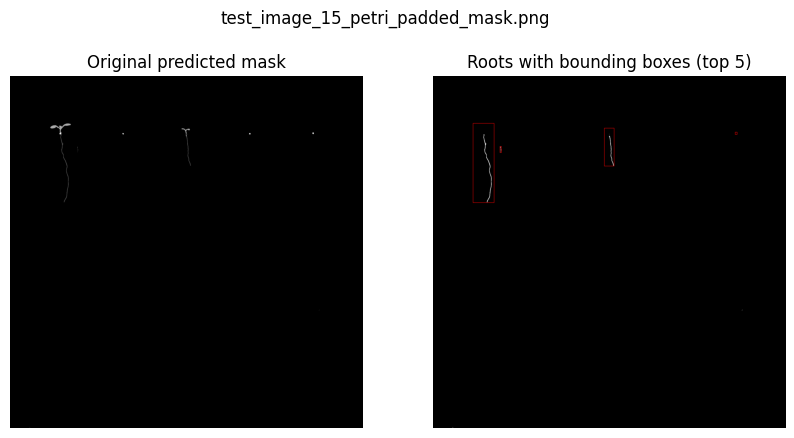

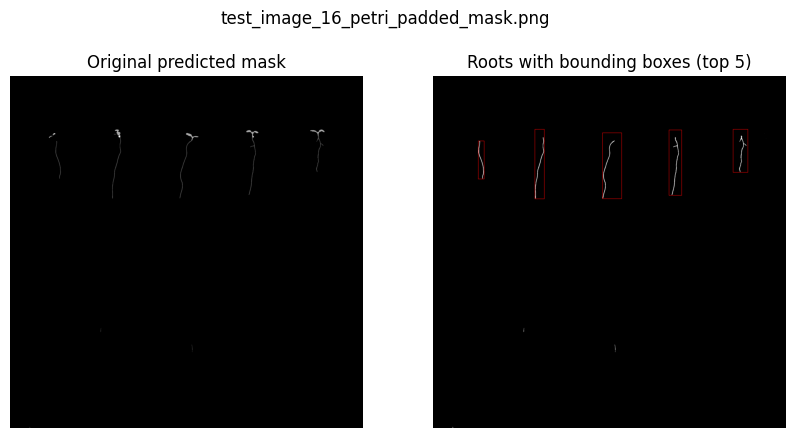

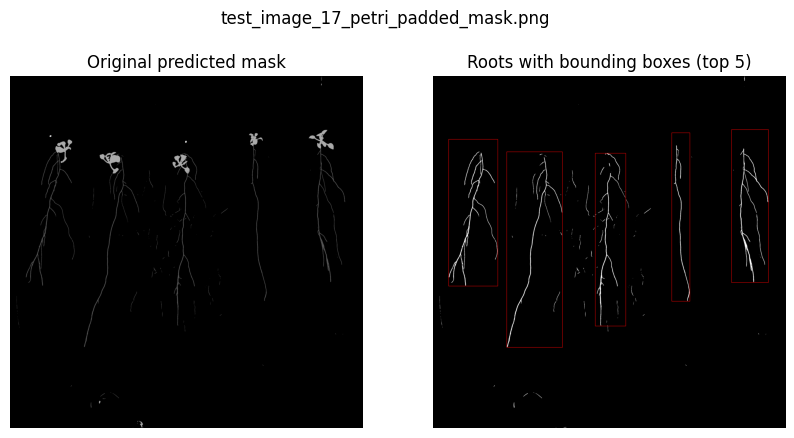

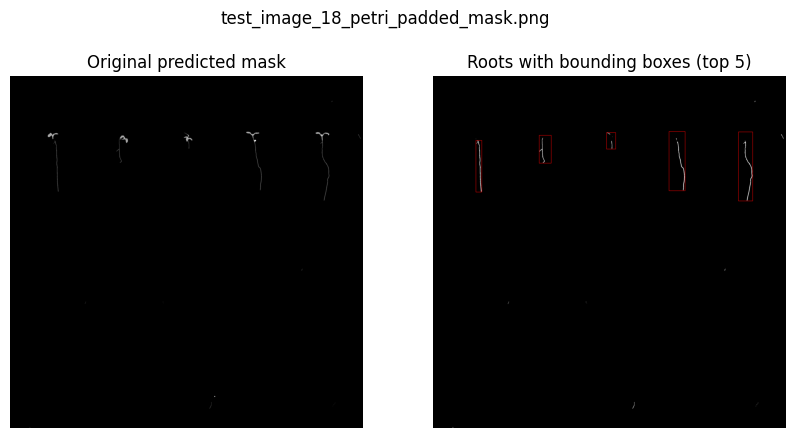

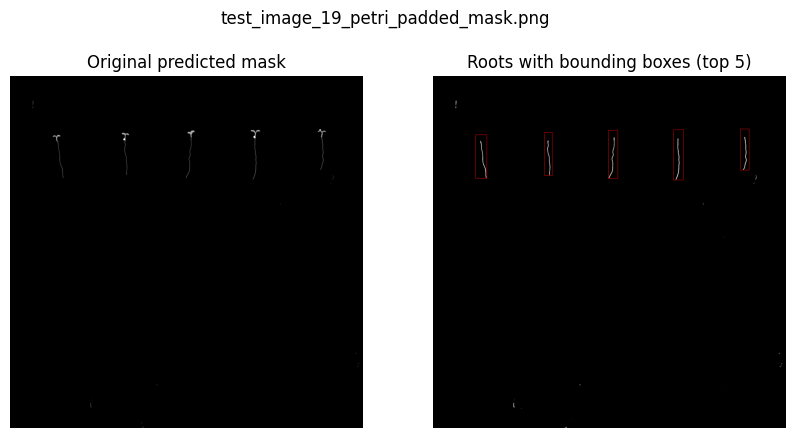

In [34]:
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

pred_dir = r"Kaggle\pred_masks_dish"
mask_paths = sorted(glob.glob(os.path.join(pred_dir, "*_mask.png")))
print("Found masks:", len(mask_paths))

kernel = np.ones((3, 3), np.uint8)
TOP_K = 5          # max number of roots/plants
AREA_MIN = 200     # ignore very small components

for mask_path in mask_paths:

    # 1) Load predicted mask (0/255)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print("  WARNING: could not read", mask_path)
        continue

    # 2) Convert to binary root mask
    root_mask = (mask > 0).astype(np.uint8)

    # 3) Morphology to clean roots
    root_clean = cv2.dilate(root_mask, kernel, iterations=3)
    root_clean = cv2.erode(root_clean, kernel, iterations=1)

    # 4) Connected components
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(
        root_clean, connectivity=8
    )

    # Areas of components 1..N
    areas = stats[1:, cv2.CC_STAT_AREA]
    labels_idx = np.arange(1, retval)

    # Sort labels by area, descending
    sorted_idx = labels_idx[np.argsort(-areas)]

    # Keep up to TOP_K components
    top_k = min(TOP_K, len(sorted_idx))
    root_labels = sorted_idx[:top_k]

    # 5) Create visualization (3-channel)
    vis_bg = (mask == 1).astype(np.uint8)
    vis_bg = (vis_bg * 255).astype(np.uint8)        # 0/1 → 0/255
    vis = cv2.cvtColor(vis_bg, cv2.COLOR_GRAY2BGR)
    
    # Draw boxes on selected components
    for label in root_labels:
        x = stats[label, cv2.CC_STAT_LEFT]
        y = stats[label, cv2.CC_STAT_TOP]
        w = stats[label, cv2.CC_STAT_WIDTH]
        h = stats[label, cv2.CC_STAT_HEIGHT]
        area = stats[label, cv2.CC_STAT_AREA]

        if area < AREA_MIN:
            continue

        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # 6) DISPLAY RESULTS SIDE-BY-SIDE
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(mask, cmap="gray")
    ax[0].set_title("Original predicted mask")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Roots with bounding boxes (top {top_k})")
    ax[1].axis("off")

    plt.suptitle(os.path.basename(mask_path))
    plt.show()


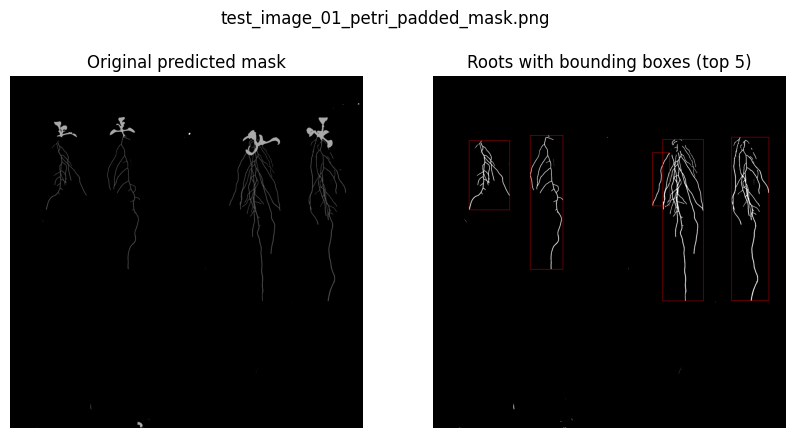

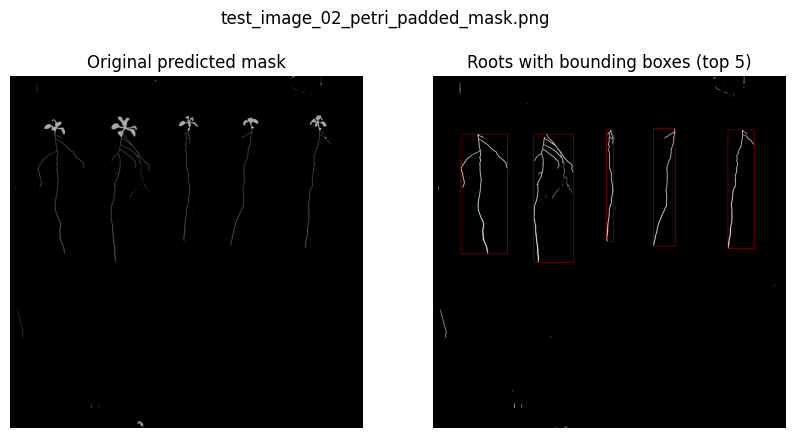

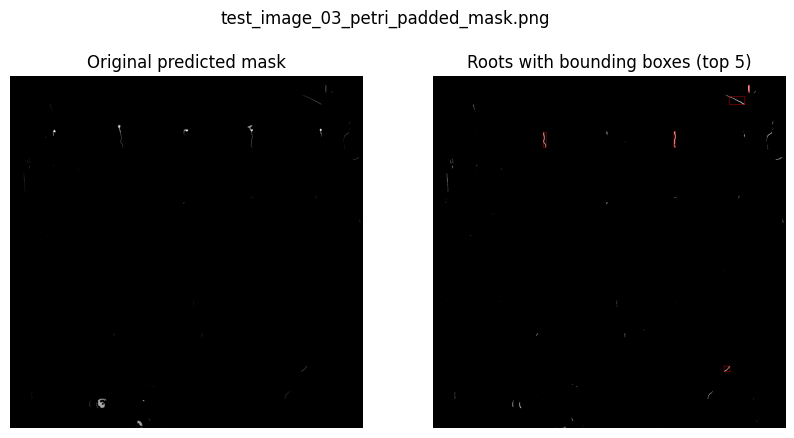

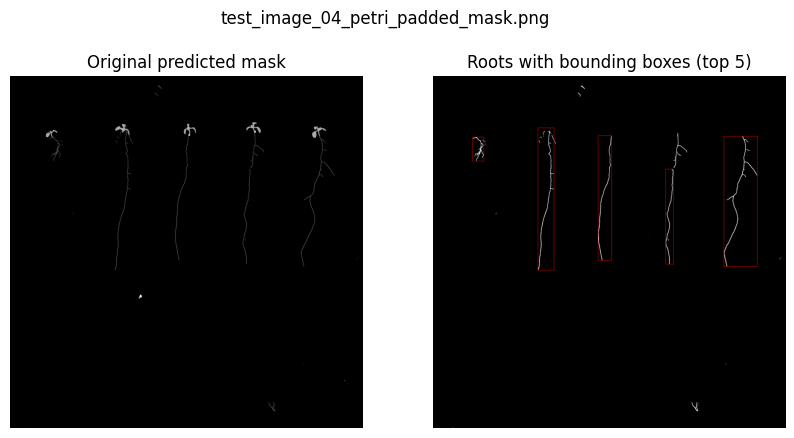

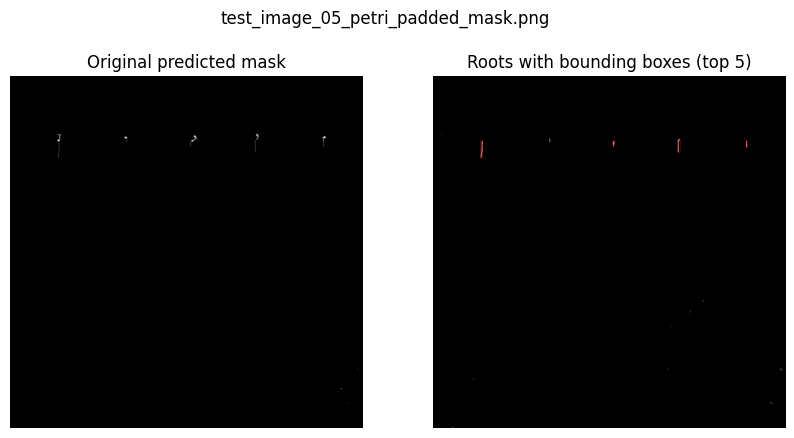

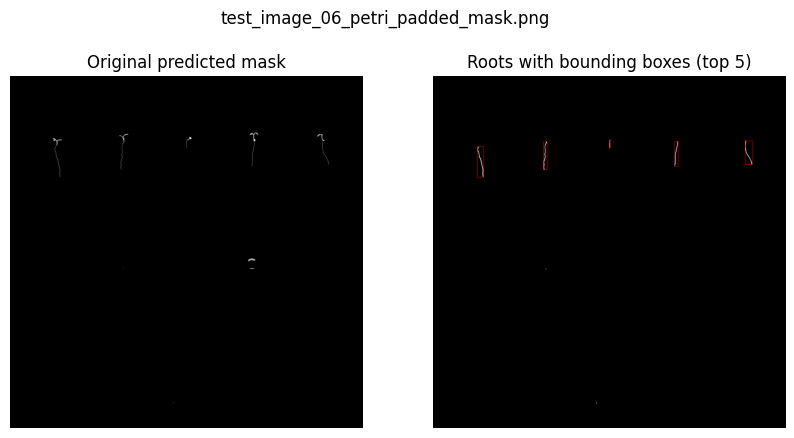

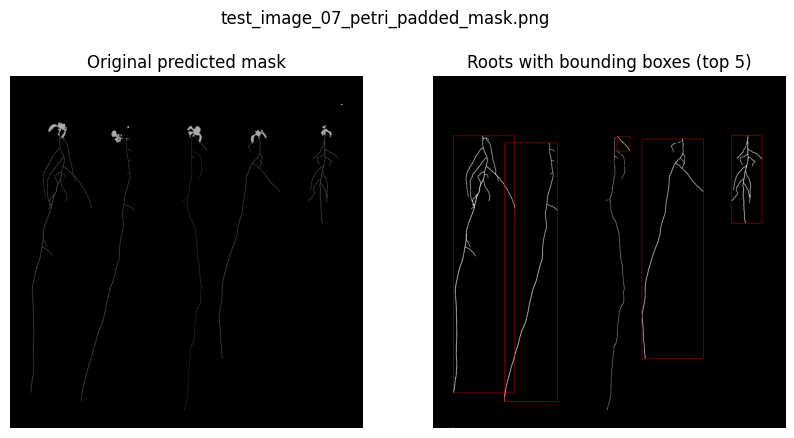

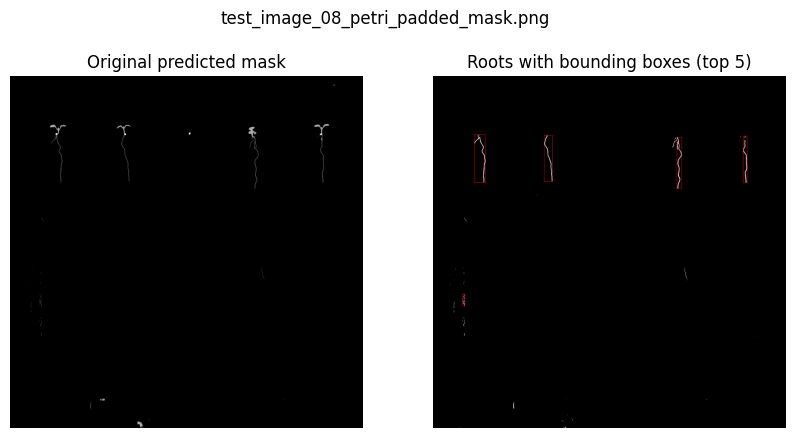

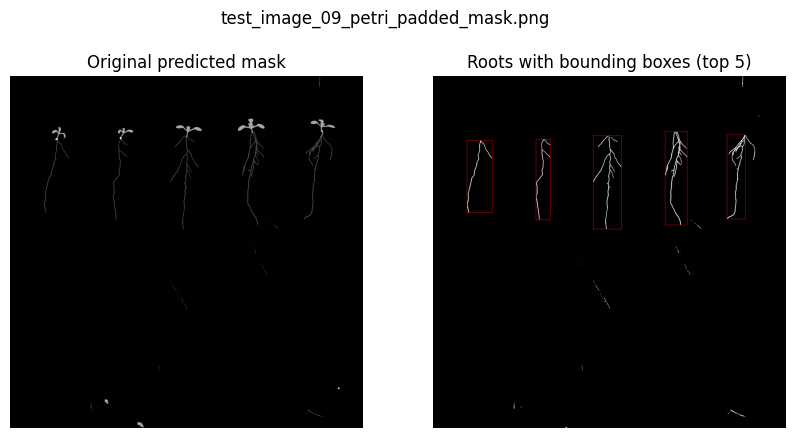

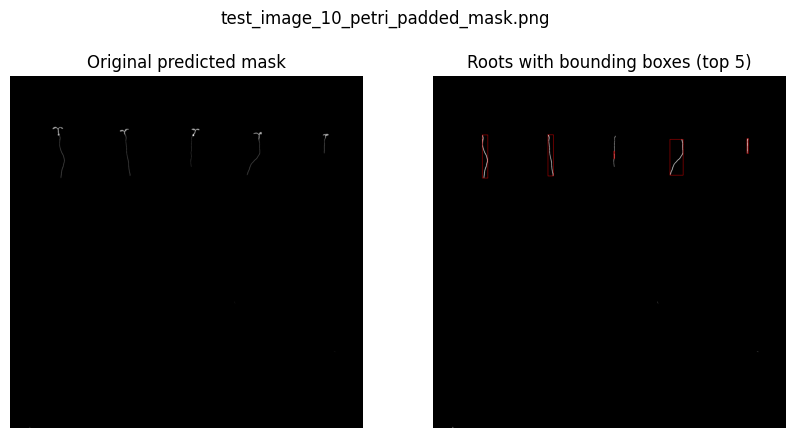

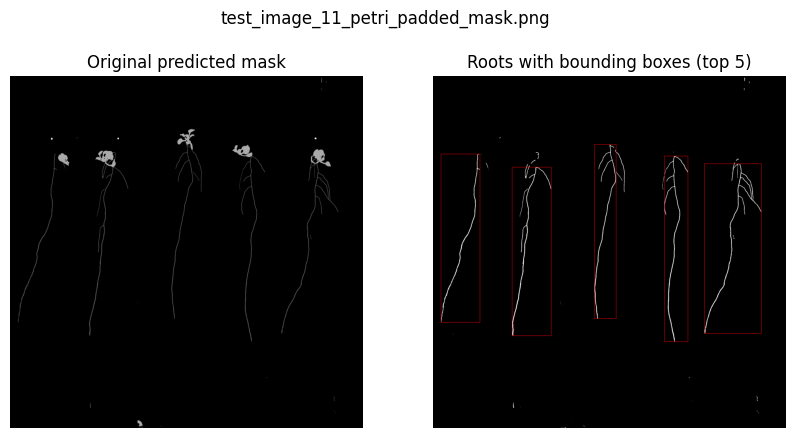

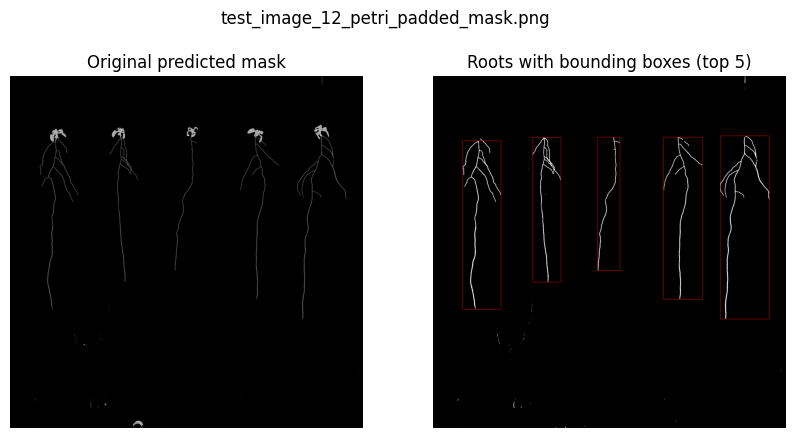

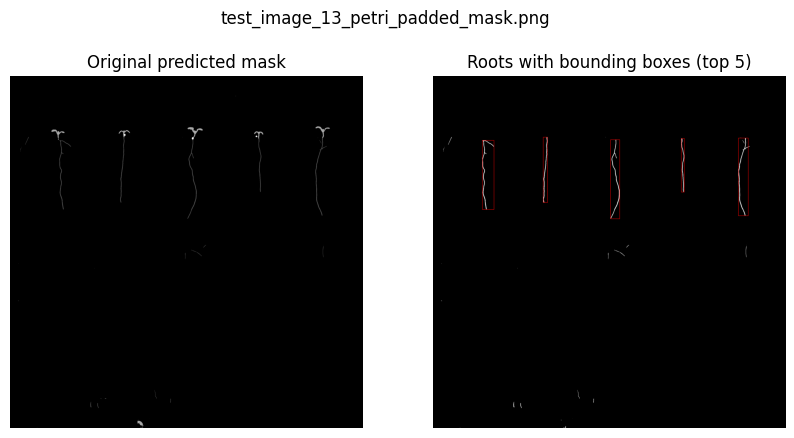

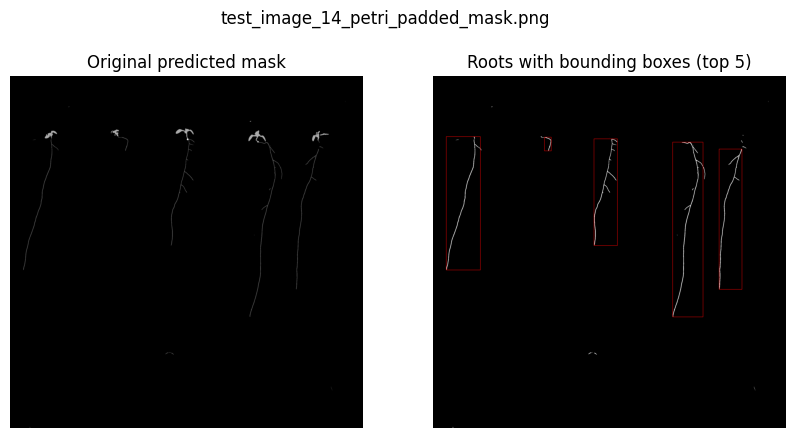

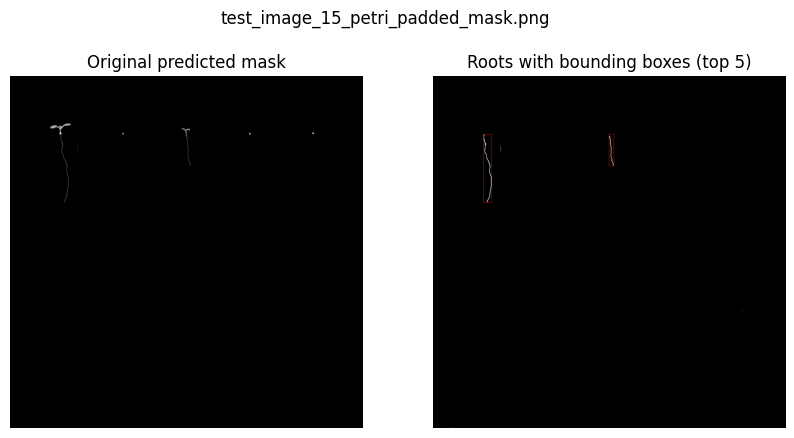

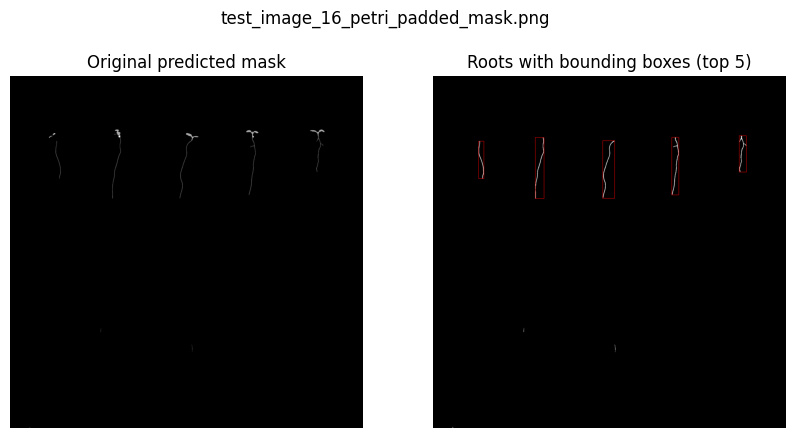

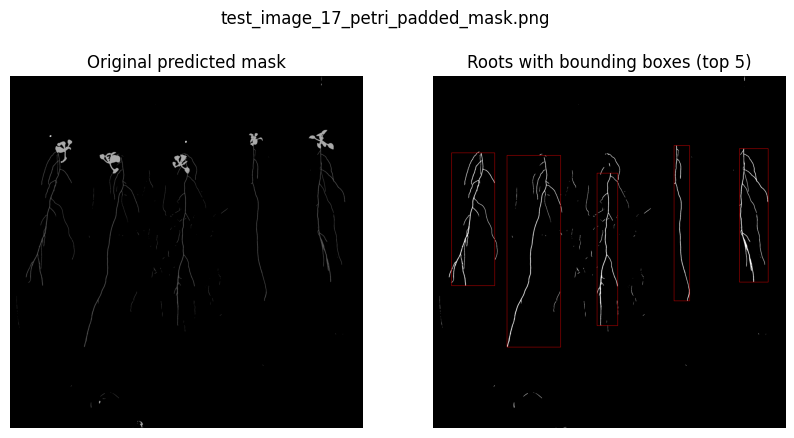

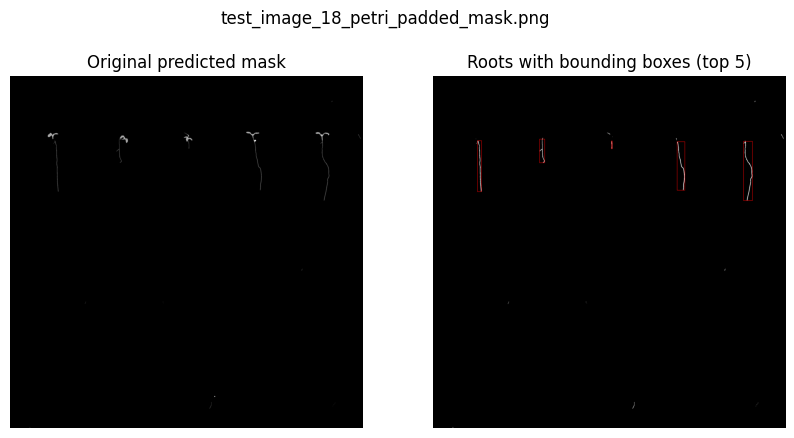

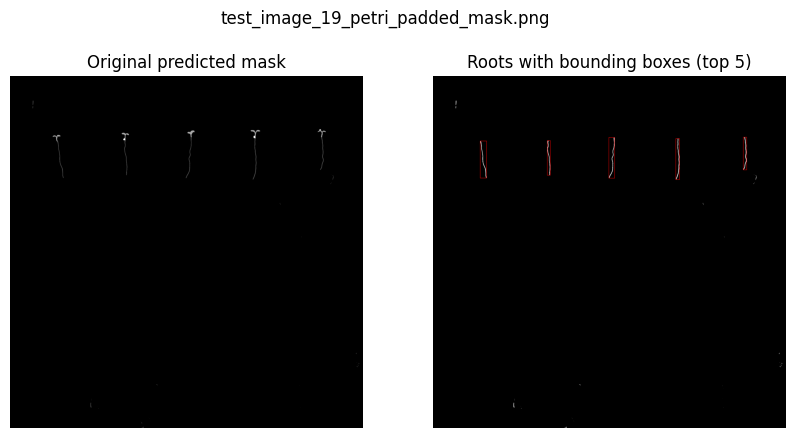

In [35]:
TOP_K = 5          # max number of roots/plants
AREA_MIN = 200     # ignore very small components

for mask_path in mask_paths:

    # 1) Load predicted mask (0/255)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print("  WARNING: could not read", mask_path)
        continue

    # 2) Convert to binary root mask
    root_mask = (mask == 1).astype(np.uint8)

    # 3) Morphology to reconnect thin vertical roots
    kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 33))
    root_closed = cv2.morphologyEx(root_mask, cv2.MORPH_CLOSE, kernel_vert)

    kernel_small = np.ones((3, 3), np.uint8)
    root_clean = cv2.morphologyEx(root_closed, cv2.MORPH_OPEN, kernel_small)

    # 4) Connected components
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(
        root_clean, connectivity=8
    )

    # Areas of components 1..N
    areas = stats[1:, cv2.CC_STAT_AREA]
    labels_idx = np.arange(1, retval)

    # Sort labels by area, descending
    sorted_idx = labels_idx[np.argsort(-areas)]

    # Keep up to TOP_K components
    top_k = min(TOP_K, len(sorted_idx))
    root_labels = sorted_idx[:top_k]

    # 5) Create visualization (3-channel)
    vis_bg = (mask == 1).astype(np.uint8)
    vis_bg = (vis_bg * 255).astype(np.uint8)        # 0/1 → 0/255
    vis = cv2.cvtColor(vis_bg, cv2.COLOR_GRAY2BGR)
    
    # Draw boxes on selected components
    for label in root_labels:
        x = stats[label, cv2.CC_STAT_LEFT]
        y = stats[label, cv2.CC_STAT_TOP]
        w = stats[label, cv2.CC_STAT_WIDTH]
        h = stats[label, cv2.CC_STAT_HEIGHT]
        area = stats[label, cv2.CC_STAT_AREA]

        if area < AREA_MIN:
            continue

        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # 6) DISPLAY RESULTS SIDE-BY-SIDE
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(mask, cmap="gray")
    ax[0].set_title("Original predicted mask")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Roots with bounding boxes (top {top_k})")
    ax[1].axis("off")

    plt.suptitle(os.path.basename(mask_path))
    plt.show()



Processing: test_image_01_petri_padded_mask.png
  plants detected: 4


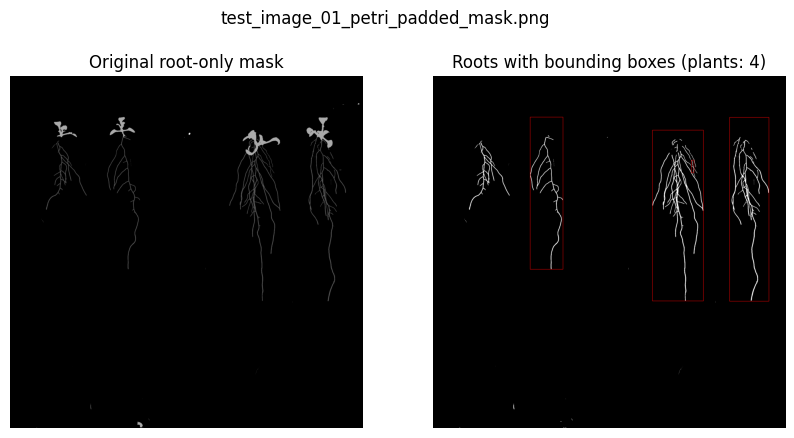


Processing: test_image_02_petri_padded_mask.png
  plants detected: 7


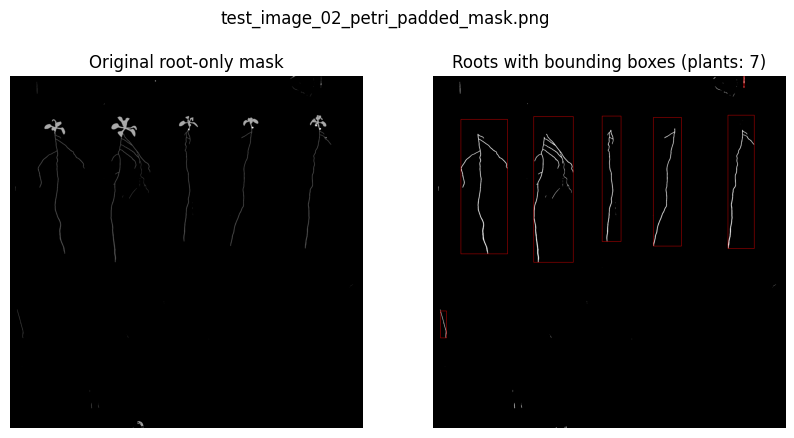


Processing: test_image_03_petri_padded_mask.png
  plants detected: 2


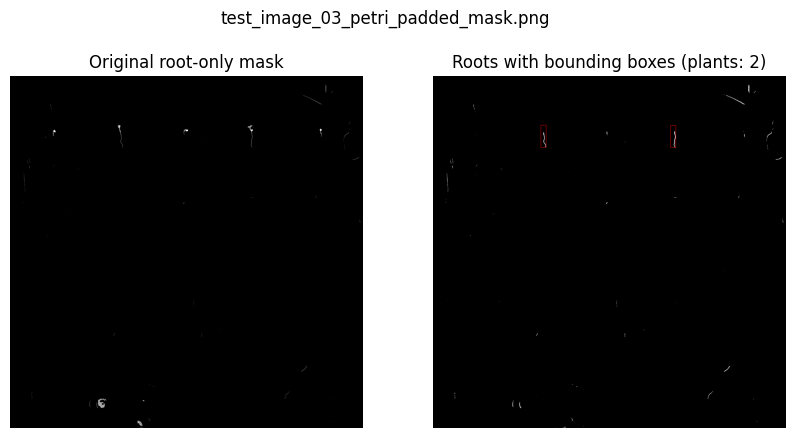


Processing: test_image_04_petri_padded_mask.png
  plants detected: 5


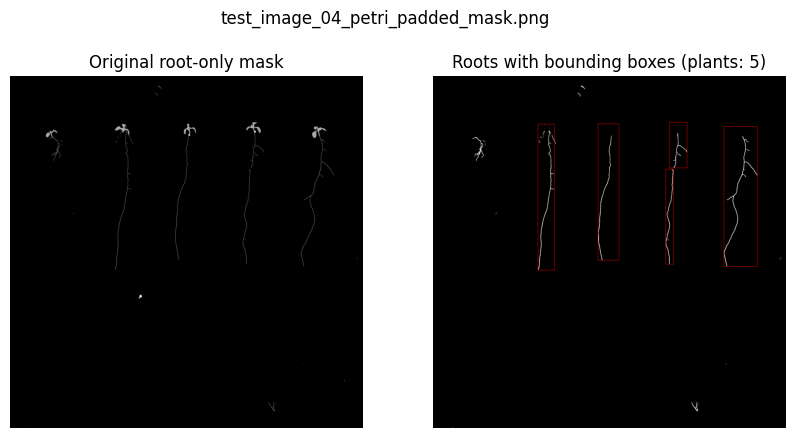


Processing: test_image_05_petri_padded_mask.png
  plants detected: 3


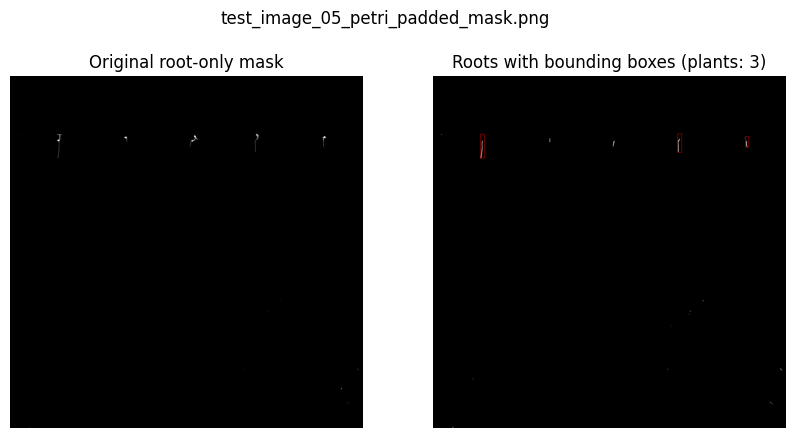


Processing: test_image_06_petri_padded_mask.png
  plants detected: 4


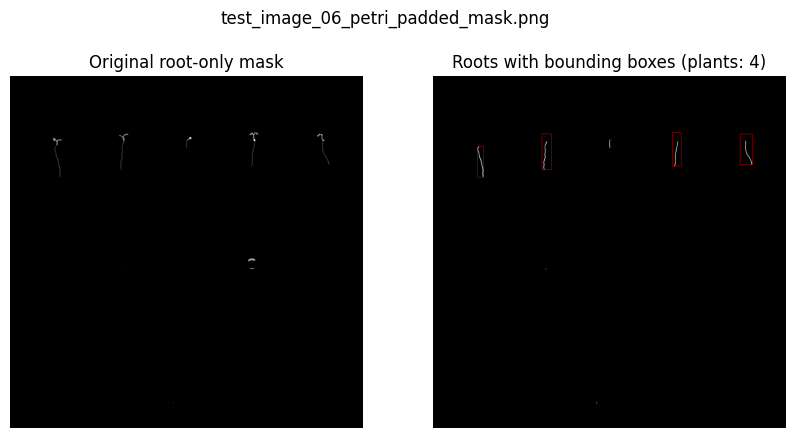


Processing: test_image_07_petri_padded_mask.png
  plants detected: 5


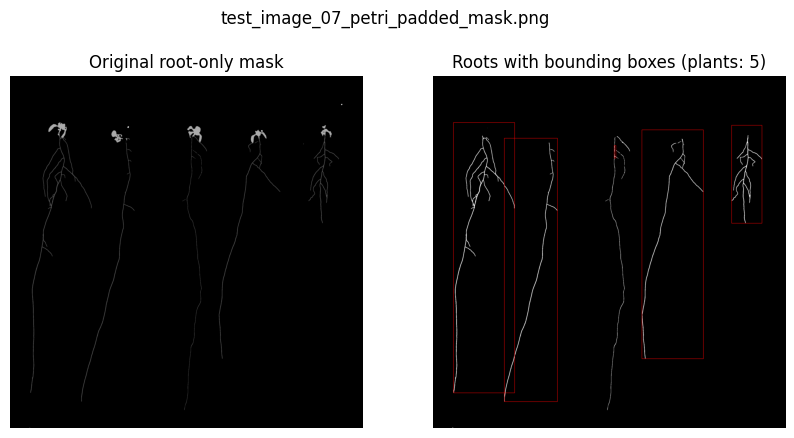


Processing: test_image_08_petri_padded_mask.png
  plants detected: 4


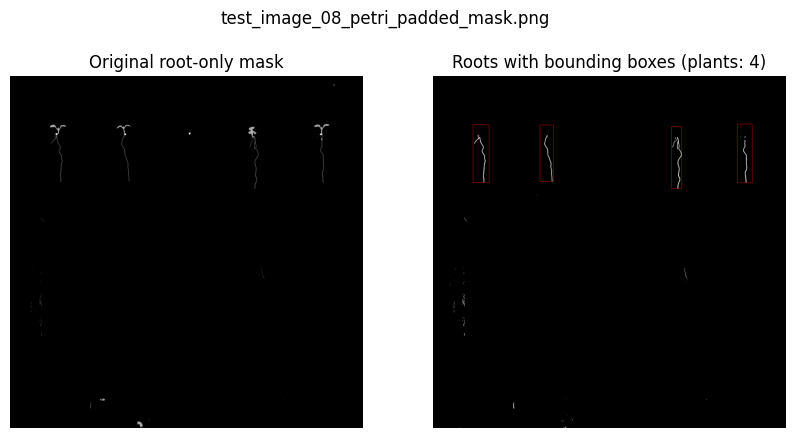


Processing: test_image_09_petri_padded_mask.png
  plants detected: 7


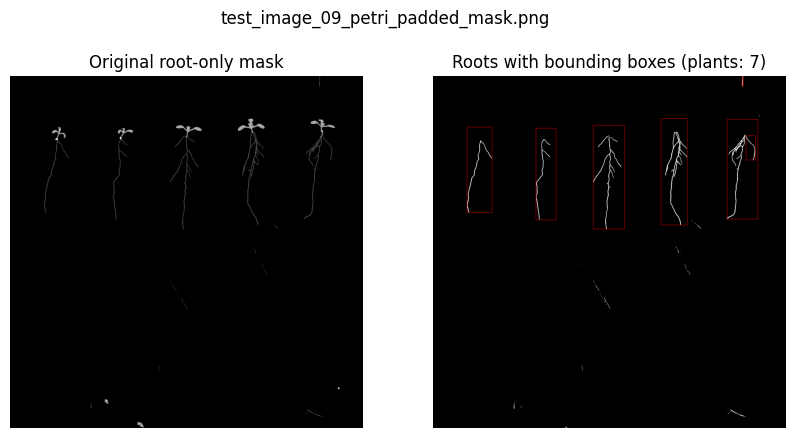


Processing: test_image_10_petri_padded_mask.png
  plants detected: 4


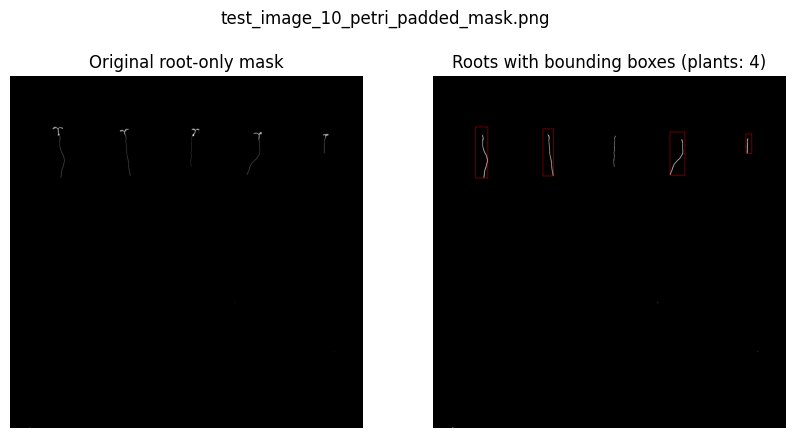


Processing: test_image_11_petri_padded_mask.png
  plants detected: 5


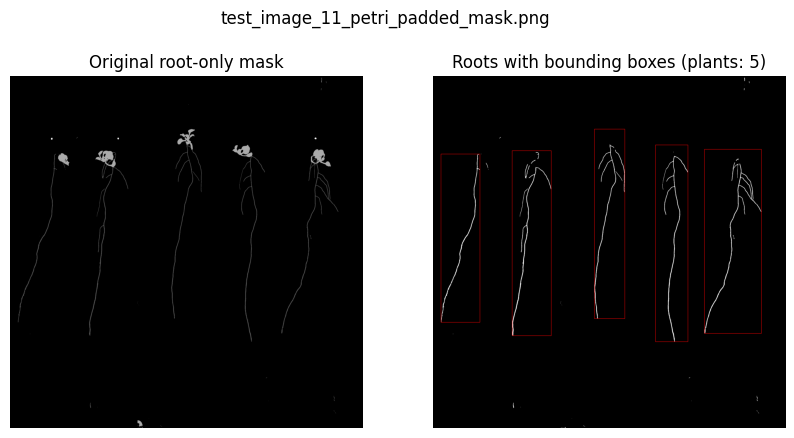


Processing: test_image_12_petri_padded_mask.png
  plants detected: 5


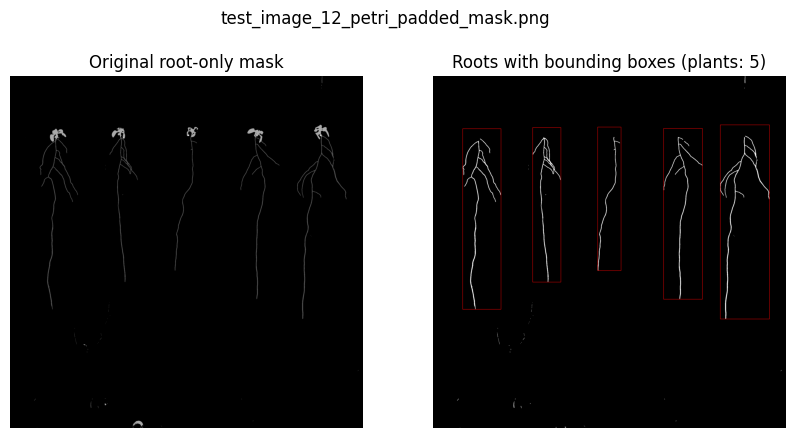


Processing: test_image_13_petri_padded_mask.png
  plants detected: 5


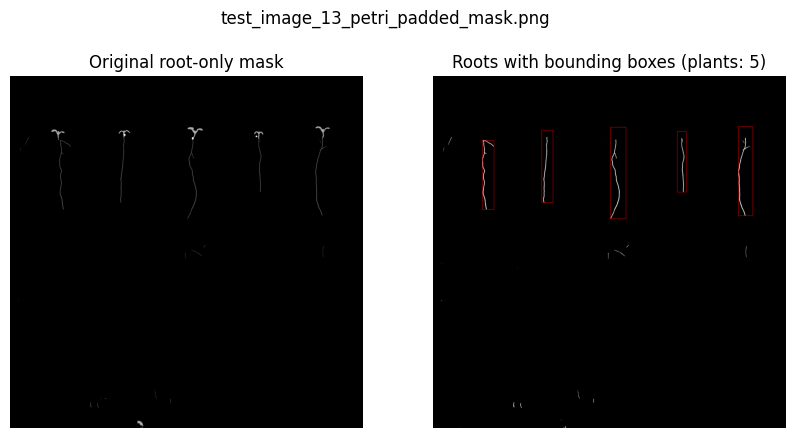


Processing: test_image_14_petri_padded_mask.png
  plants detected: 5


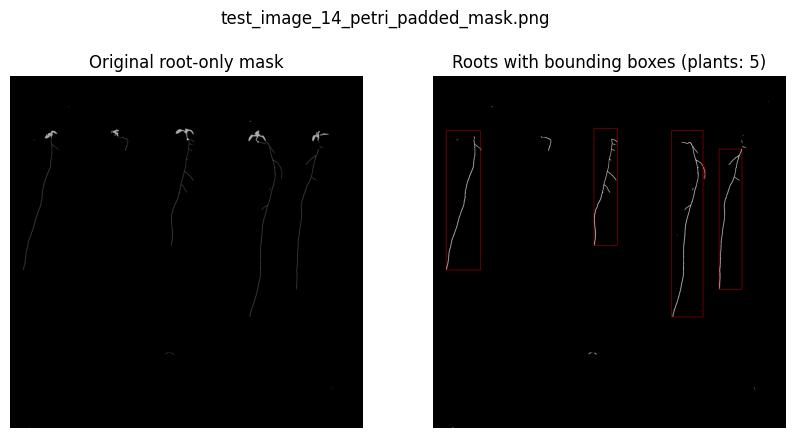


Processing: test_image_15_petri_padded_mask.png
  plants detected: 2


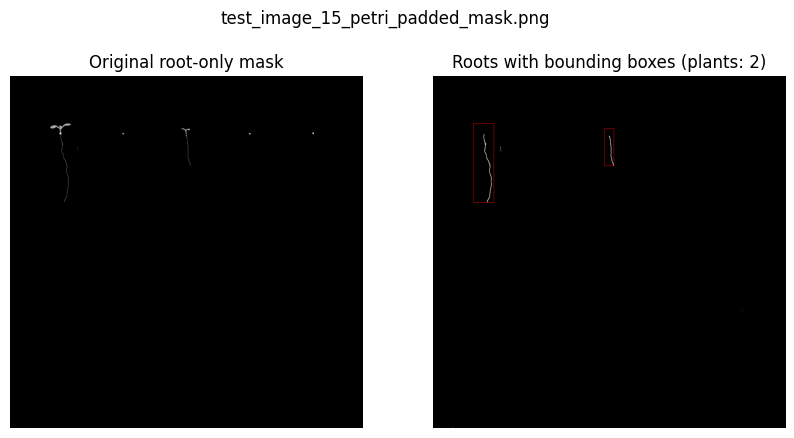


Processing: test_image_16_petri_padded_mask.png
  plants detected: 5


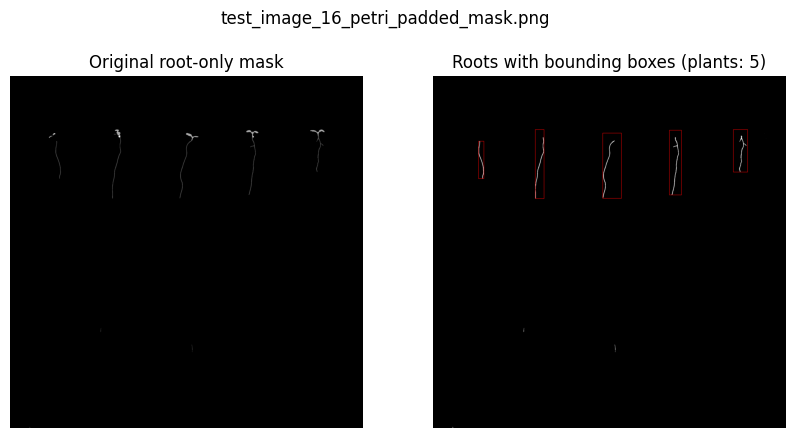


Processing: test_image_17_petri_padded_mask.png
  plants detected: 7


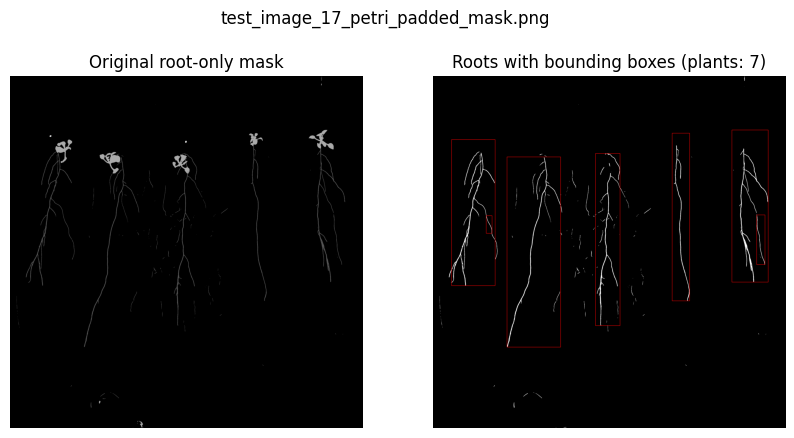


Processing: test_image_18_petri_padded_mask.png
  plants detected: 4


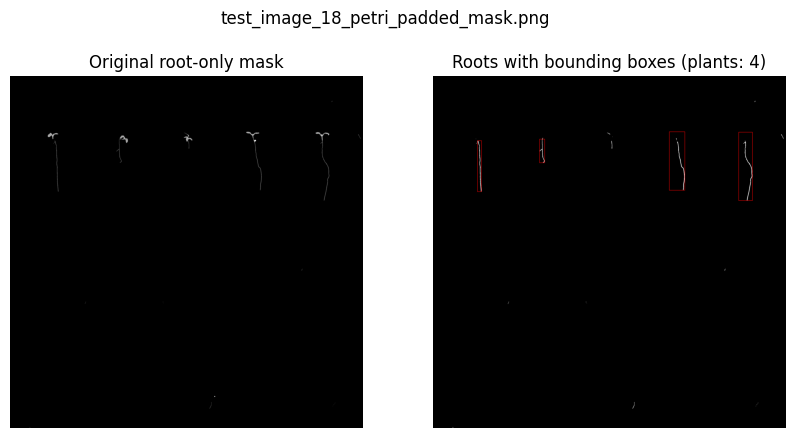


Processing: test_image_19_petri_padded_mask.png
  plants detected: 5


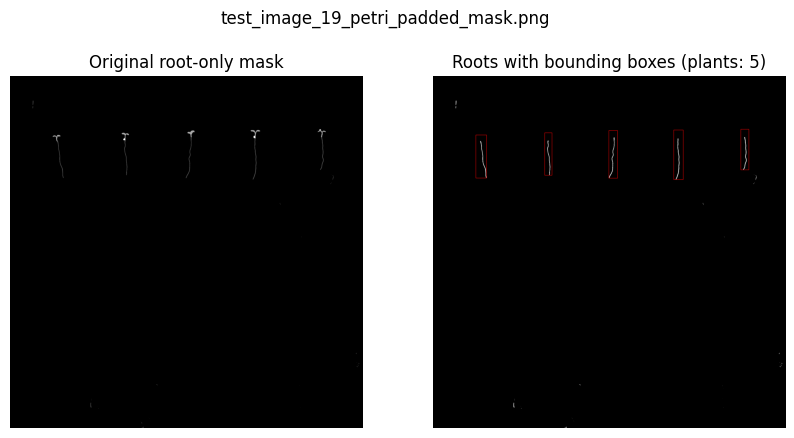

In [36]:
AREA_MIN   = 150      # ignore very small components
HEIGHT_MIN = 80       # roots should be at least this tall (px)
ASPECT_MIN = 2.5      # ignore very small components

for mask_path in mask_paths:
    print("\nProcessing:", os.path.basename(mask_path))

    # 1) Load predicted mask (root-only, 0/255)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print("  WARNING: could not read", mask_path)
        continue

    # 2) Binary root mask 0/1
    root_mask = (mask > 0).astype(np.uint8)

    # 3) Morphology to reconnect thin vertical roots
    kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 21))
    root_closed = cv2.morphologyEx(root_mask, cv2.MORPH_CLOSE, kernel_vert)

    kernel_small = np.ones((3, 3), np.uint8)
    root_clean = cv2.morphologyEx(root_closed, cv2.MORPH_OPEN, kernel_small)

    # 4) Connected components on cleaned roots
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(
        root_clean, connectivity=8
    )

    plant_labels = []

    for label in range(1, retval):  # skip background
        x = stats[label, cv2.CC_STAT_LEFT]
        y = stats[label, cv2.CC_STAT_TOP]
        w = stats[label, cv2.CC_STAT_WIDTH]
        h = stats[label, cv2.CC_STAT_HEIGHT]
        area = stats[label, cv2.CC_STAT_AREA]

        # geometric filtering: size + shape
        if area < AREA_MIN:
            continue
        if h < HEIGHT_MIN:
            continue

        aspect = h / max(w, 1)     # tall & thin
        if aspect < ASPECT_MIN:
            continue

        plant_labels.append(label)

    # sort left→right by x
    plant_labels.sort(key=lambda lab: stats[lab, cv2.CC_STAT_LEFT])

    print("  plants detected:", len(plant_labels))

    # 5) Create visualization (use cleaned mask as background)
    vis_bg = (mask == 1).astype(np.uint8)
    vis_bg = (vis_bg * 255).astype(np.uint8)        # 0/1 → 0/255
    vis = cv2.cvtColor(vis_bg, cv2.COLOR_GRAY2BGR)

    for label in plant_labels:
        x = stats[label, cv2.CC_STAT_LEFT]
        y = stats[label, cv2.CC_STAT_TOP]
        w = stats[label, cv2.CC_STAT_WIDTH]
        h = stats[label, cv2.CC_STAT_HEIGHT]

        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # 6) DISPLAY RESULTS SIDE-BY-SIDE
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(mask, cmap="gray")
    ax[0].set_title("Original root-only mask")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Roots with bounding boxes (plants: {len(plant_labels)})")
    ax[1].axis("off")

    plt.suptitle(os.path.basename(mask_path))
    plt.show()

Plants detected: 5


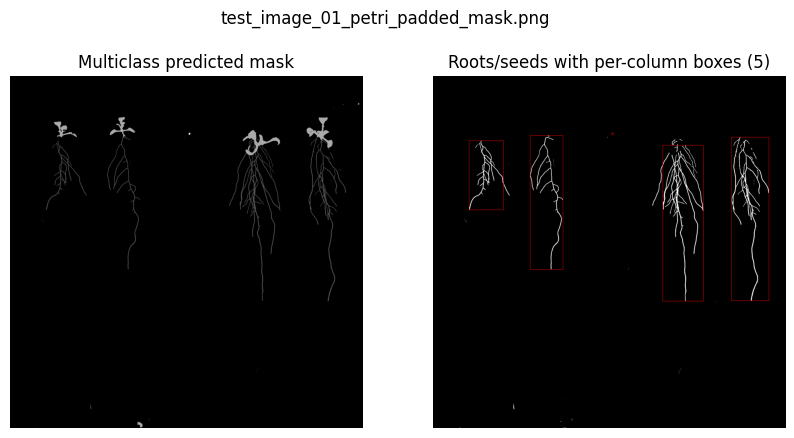

Plants detected: 5


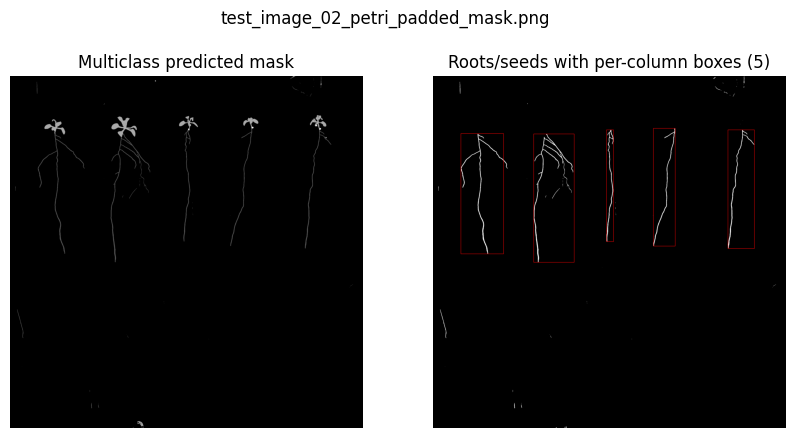

Plants detected: 5


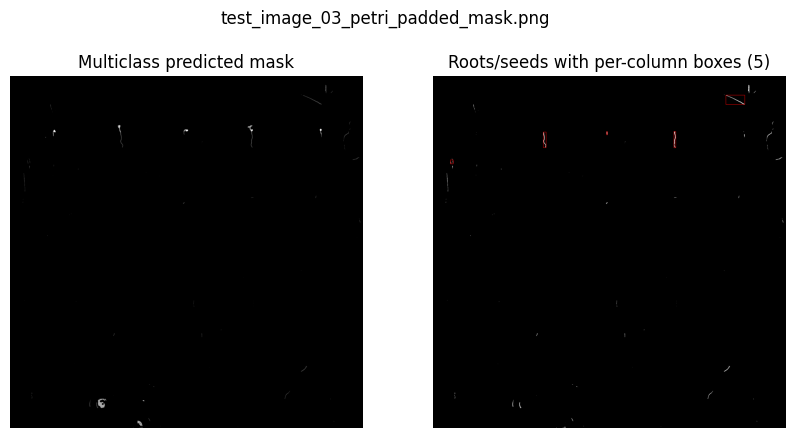

Plants detected: 5


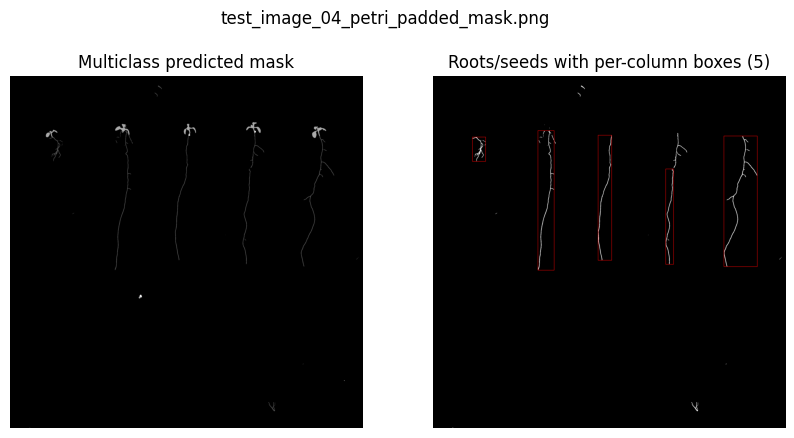

Plants detected: 5


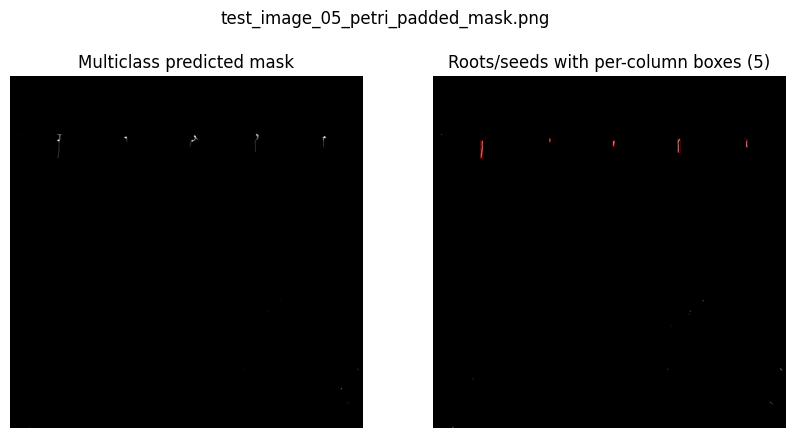

Plants detected: 5


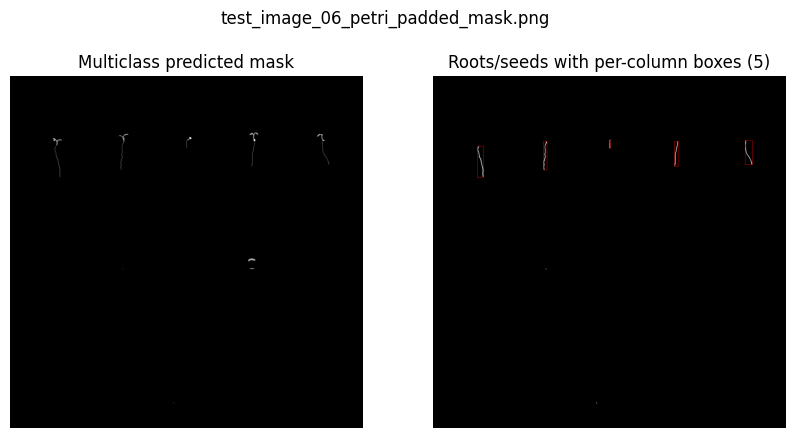

Plants detected: 5


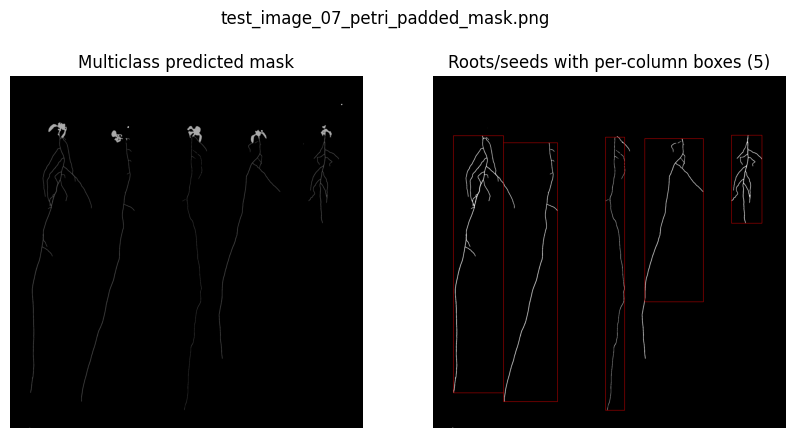

Plants detected: 5


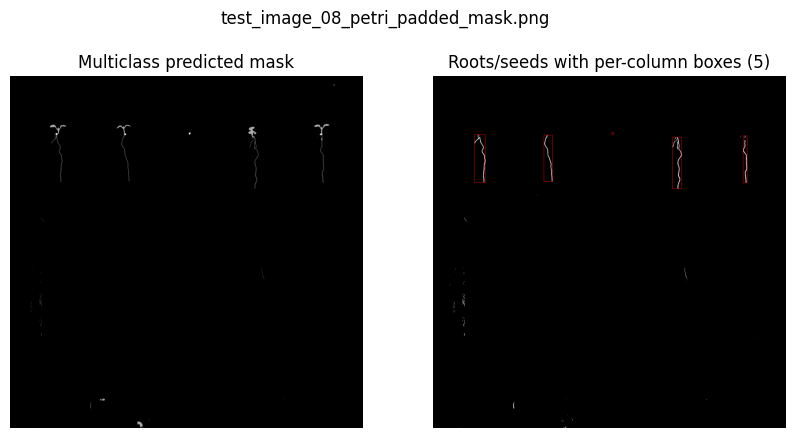

Plants detected: 5


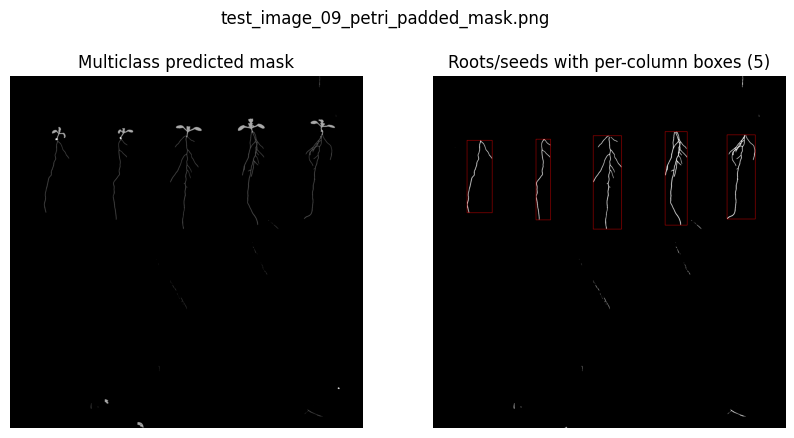

Plants detected: 5


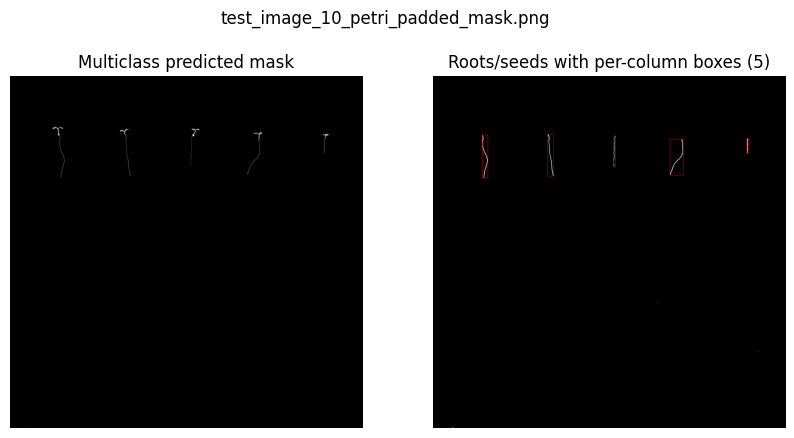

Plants detected: 5


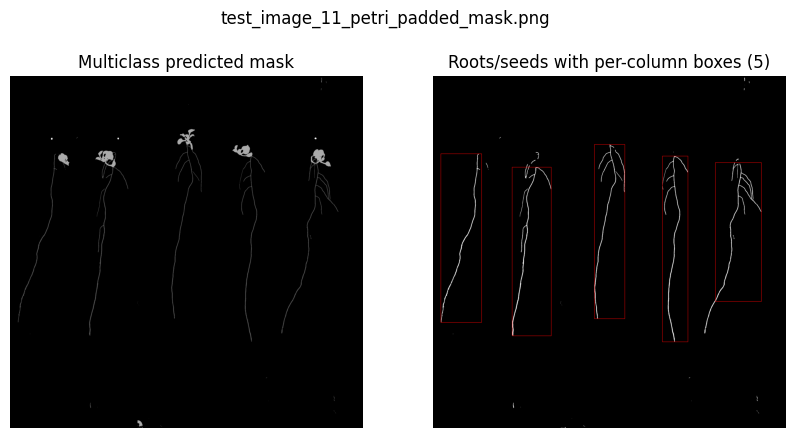

Plants detected: 5


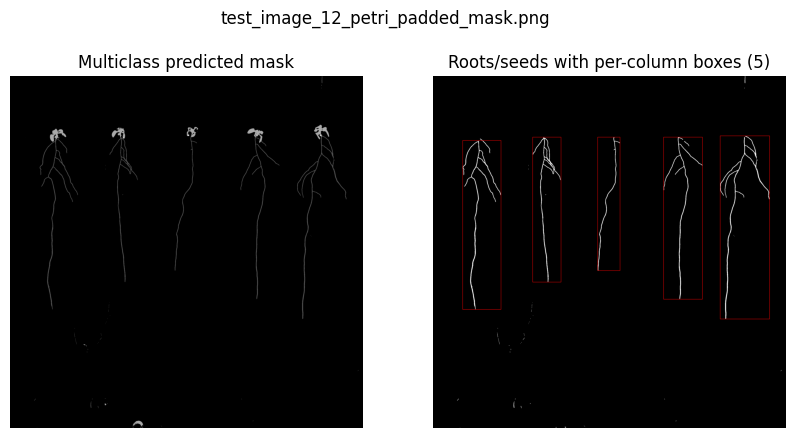

Plants detected: 5


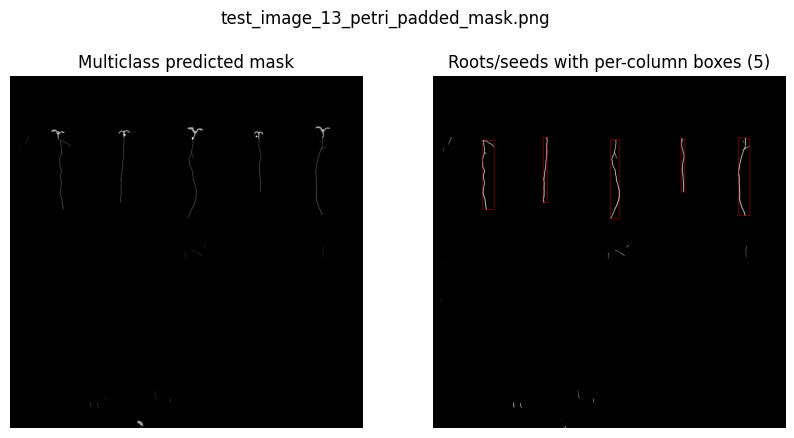

Plants detected: 5


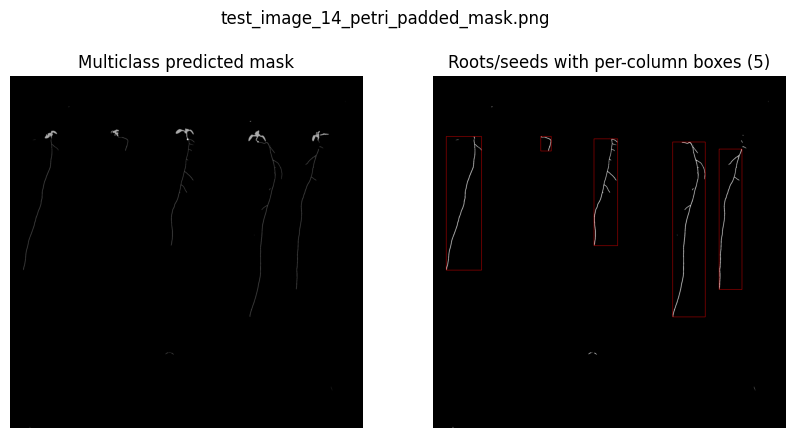

Plants detected: 5


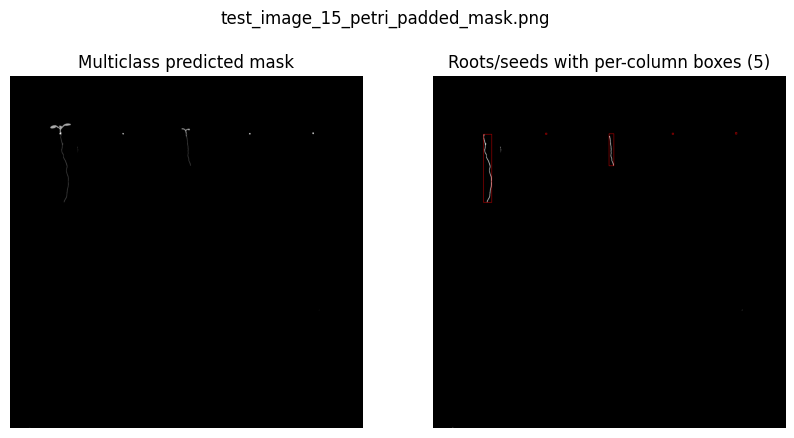

Plants detected: 5


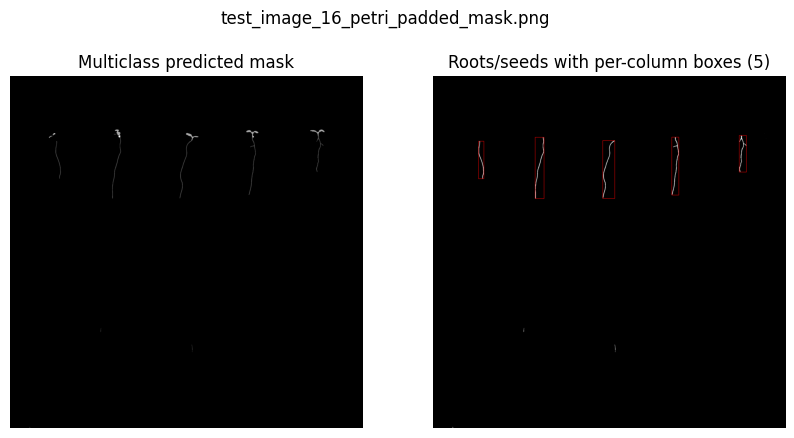

Plants detected: 5


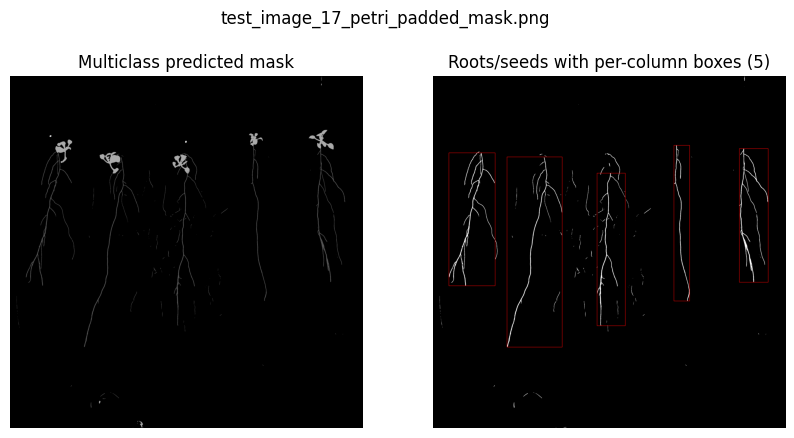

Plants detected: 5


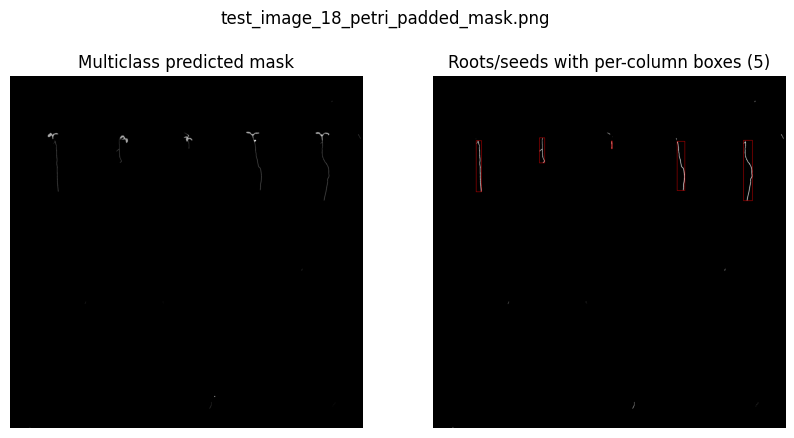

Plants detected: 5


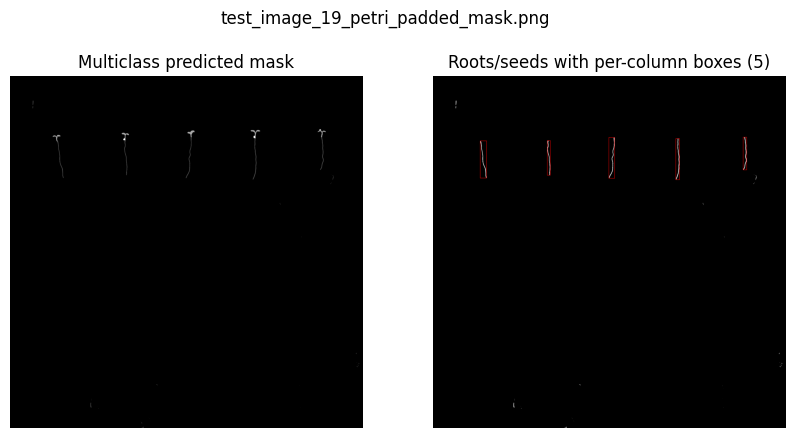

In [37]:
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# geometry thresholds
ROOT_AREA_MIN   = 80    # minimal area for root component
ROOT_HEIGHT_MIN = 20    # minimal height
ROOT_ASPECT_MIN = 2.0   # h / w


SEED_AREA_MIN   = 20    # minimal area for seed/shoot when no root
SEED_HEIGHT_MAX = 80    # seeds/shoots are short blobs


for mask_path in mask_paths:

    # load label mask (values 0..3)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print("  WARNING: could not read", mask_path)
        continue

    H, W = mask.shape

    # define 5 vertical columns
    cols = np.linspace(0, W, 6, dtype=int)   # 6 boundaries -> 5 columns

    # for visualization: show roots+seeds+shoots as bright
    vis_bg = (mask == 1).astype(np.uint8) * 255
    vis = cv2.cvtColor(vis_bg, cv2.COLOR_GRAY2BGR)

    plant_boxes = []

    for col_idx in range(5):
        x0, x1 = cols[col_idx], cols[col_idx + 1]
        col = mask[:, x0:x1]   # labels in this column only

        # ROOT PASS
        root_col = (col == 1).astype(np.uint8)

        # small vertical closing to connect thin roots
        kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 15))
        root_closed = cv2.morphologyEx(root_col, cv2.MORPH_CLOSE, kernel_vert)

        kernel_horz = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))
        root_closed = cv2.morphologyEx(root_closed, cv2.MORPH_CLOSE, kernel_horz)

        kernel_small = np.ones((15, 15), np.uint8)
        root_clean = cv2.morphologyEx(root_closed, cv2.MORPH_OPEN, kernel_small)

        num_r, lab_r, stats_r, cent_r = cv2.connectedComponentsWithStats(
            root_closed, connectivity=8
        )

        best_root = None
        best_root_score = -np.inf

        for lab in range(1, num_r):
            x, y, w, h, area = stats_r[lab]

            if area < ROOT_AREA_MIN or h < ROOT_HEIGHT_MIN:
                continue

            aspect = h / max(w, 1)
            # if aspect < ROOT_ASPECT_MIN:
            #     continue

            score = area  # simple combined score
            if score > best_root_score:
                best_root_score = score
                best_root = (x, y, w, h)

        # if no good root -> SEED/SHOOT PASS
        if best_root is None:
            seed_col = ((col == 2) | (col == 3)).astype(np.uint8)
            num_s, lab_s, stats_s, cent_s = cv2.connectedComponentsWithStats(
                seed_col, connectivity=8
            )

            best_seed = None
            best_seed_area = -np.inf

            for lab in range(1, num_s):
                x, y, w, h, area = stats_s[lab]

                if area < SEED_AREA_MIN:
                    continue
                if h > SEED_HEIGHT_MAX:
                    continue

                if area > best_seed_area:
                    best_seed_area = area
                    best_seed = (x, y, w, h)

            if best_seed is None:
                # nothing in this column -> no plant (or not detected)
                continue

            # convert column-local coords to full-image coords
            x, y, w, h = best_seed
            plant_boxes.append((x0 + x, y, w, h))
        else:
            # we found a root component
            x, y, w, h = best_root
            plant_boxes.append((x0 + x, y, w, h))

    print("Plants detected:", len(plant_boxes))

    # draw final boxes
    for (x, y, w, h) in plant_boxes:
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # display mask and mask + boxes
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(mask, cmap="gray")
    ax[0].set_title("Multiclass predicted mask")
    ax[0].axis("off")

    ax[1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Roots/seeds with per-column boxes ({len(plant_boxes)})")
    ax[1].axis("off")

    plt.suptitle(os.path.basename(mask_path))
    plt.show()


In [53]:
import glob, os, cv2, numpy as np
from pathlib import Path

mask_paths = sorted(glob.glob(r"Kaggle\pred_masks_dish\*_mask.png"))

# geometry thresholds
ROOT_AREA_MIN   = 80    # minimal area for root component
ROOT_HEIGHT_MIN = 20    # minimal height
ROOT_ASPECT_MIN = 2.0   # h / w


SEED_AREA_MIN   = 20    # minimal area for seed/shoot when no root
SEED_HEIGHT_MAX = 80    # seeds/shoots are short blobs

out_dir = Path("Kaggle/root_systems")
out_dir.mkdir(parents=True, exist_ok=True)

for mask_path in mask_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print("  WARNING: could not read", mask_path)
        continue

    H, W = mask.shape
    cols = np.linspace(0, W, 6, dtype=int)   # 5 columns

    vis_bg = (mask == 1).astype(np.uint8) * 255
    vis = cv2.cvtColor(vis_bg, cv2.COLOR_GRAY2BGR)

    plant_boxes = []

    for col_idx in range(5):
        x0, x1 = cols[col_idx], cols[col_idx + 1]
        col = mask[:, x0:x1]

        root_col = (col == 1).astype(np.uint8)
        kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 15))
        root_closed = cv2.morphologyEx(root_col, cv2.MORPH_CLOSE, kernel_vert)
        kernel_horz = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))
        root_closed = cv2.morphologyEx(root_closed, cv2.MORPH_CLOSE, kernel_horz)
        root_clean = cv2.morphologyEx(root_closed, cv2.MORPH_OPEN, np.ones((15, 15), np.uint8))

        num_r, lab_r, stats_r, _ = cv2.connectedComponentsWithStats(root_closed, connectivity=8)

        best_root = None
        best_root_score = -np.inf
        for lab in range(1, num_r):
            x, y, w, h, area = stats_r[lab]
            if area < ROOT_AREA_MIN or h < ROOT_HEIGHT_MIN:
                continue
            aspect = h / max(w, 1)
            # if aspect < ROOT_ASPECT_MIN: continue
            score = area
            if score > best_root_score:
                best_root_score = score
                best_root = (x, y, w, h)

        if best_root is None:
            seed_col = ((col == 2) | (col == 3)).astype(np.uint8)
            num_s, lab_s, stats_s, _ = cv2.connectedComponentsWithStats(seed_col, connectivity=8)

            best_seed = None
            best_seed_area = -np.inf
            for lab in range(1, num_s):
                x, y, w, h, area = stats_s[lab]
                if area < SEED_AREA_MIN: continue
                if h > SEED_HEIGHT_MAX: continue
                if area > best_seed_area:
                    best_seed_area = area
                    best_seed = (x, y, w, h)
            if best_seed is None:
                continue
            x, y, w, h = best_seed
            plant_boxes.append((x0 + x, y, w, h))
        else:
            x, y, w, h = best_root
            plant_boxes.append((x0 + x, y, w, h))

    print("Plants detected:", len(plant_boxes))

    pad = 20 # pixels of padding around each box

    # save crops as 0/255 grayscale, ordered left→right, max 5
    plant_boxes = sorted(plant_boxes, key=lambda b: b[0])[:5]
    base_name = Path(mask_path).stem.replace("_mask", "").replace("_petri_padded", "")

    for idx, (x, y, w, h) in enumerate(plant_boxes, 1):
        x0 = max(x - pad, 0)
        y0 = max(y - pad, 0)
        x1 = min(x + w + pad, W)
        y1 = min(y + h + pad, H)
        if x1 <= x0 or y1 <= y0:
            continue

        # keep only roots (label==1) in the crop, convert to 0/255 uint8
        crop_mask = (mask[y0:y1, x0:x1] == 1).astype("uint8") * 255

        out_path = out_dir / f"{base_name}_plant_{idx}.png"  # e.g., test_image_01_plant_1.png
        cv2.imwrite(str(out_path), crop_mask)
        print("  saved", out_path)


Plants detected: 5
  saved Kaggle\root_systems\test_image_01_plant_1.png
  saved Kaggle\root_systems\test_image_01_plant_2.png
  saved Kaggle\root_systems\test_image_01_plant_3.png
  saved Kaggle\root_systems\test_image_01_plant_4.png
  saved Kaggle\root_systems\test_image_01_plant_5.png
Plants detected: 5
  saved Kaggle\root_systems\test_image_02_plant_1.png
  saved Kaggle\root_systems\test_image_02_plant_2.png
  saved Kaggle\root_systems\test_image_02_plant_3.png
  saved Kaggle\root_systems\test_image_02_plant_4.png
  saved Kaggle\root_systems\test_image_02_plant_5.png
Plants detected: 5
  saved Kaggle\root_systems\test_image_03_plant_1.png
  saved Kaggle\root_systems\test_image_03_plant_2.png
  saved Kaggle\root_systems\test_image_03_plant_3.png
  saved Kaggle\root_systems\test_image_03_plant_4.png
  saved Kaggle\root_systems\test_image_03_plant_5.png
Plants detected: 5
  saved Kaggle\root_systems\test_image_04_plant_1.png
  saved Kaggle\root_systems\test_image_04_plant_2.png
  save

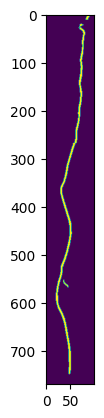

In [78]:
mask_patch = ("Kaggle/root_systems/test_image_04_plant_4.png")

mask = cv2.imread(mask_patch, 0)

plt.imshow(mask)